In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans

import torch
import torch.optim as optim
import muon as mu
import yaml
import os
import sys
from utils import plot_mse_curves,calculate_mse,find_max_index,calculate_entropy,calculate_entropies
sys.path.append('../../Autoencoder')
from autoencoder.data.scrnaseq_loader import RNAseqLoader
from autoencoder.models.base.encoder_model import EncoderModel

import argparse
from mm_diffusion.multimodal_script_util import (
    model_and_diffusion_defaults,
    create_model_and_diffusion,
    add_dict_to_argparser,
    args_to_dict
)
from mm_diffusion import dist_util
import mygene

import shutup
shutup.please()

In [2]:
def ensembl_to_gene_name(ensembl_id):
    mg = mygene.MyGeneInfo()
    result = mg.query(ensembl_id, fields="symbol")
    if "hits" in result and len(result["hits"]) > 0:
        return result["hits"][0].get("symbol", "Unknown")
    return "Unknown"

In [6]:
# type_list = np.array(['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
#         'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
#         'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
#         'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
#         'Proerythroblast', 'Transitional B', 'cDC2', 'pDC'])
type_list = np.array(['CD14+ Mono', 'ID2-hi myeloid prog', 'CD16+ Mono', 'cDC2',
                       'pDC', 'HSC', 'G/M prog','Lymph prog','MK/E prog', 'Naive CD20+ B',
                       'B1 B', 'Transitional B', 'Plasma cell','CD4+ T naive','CD4+ T activated',
         'CD8+ T', 'CD8+ T naive','NK', 'ILC', 'Proerythroblast','Erythroblast','Normoblast', ])

# attention heatmap

(256, 256)


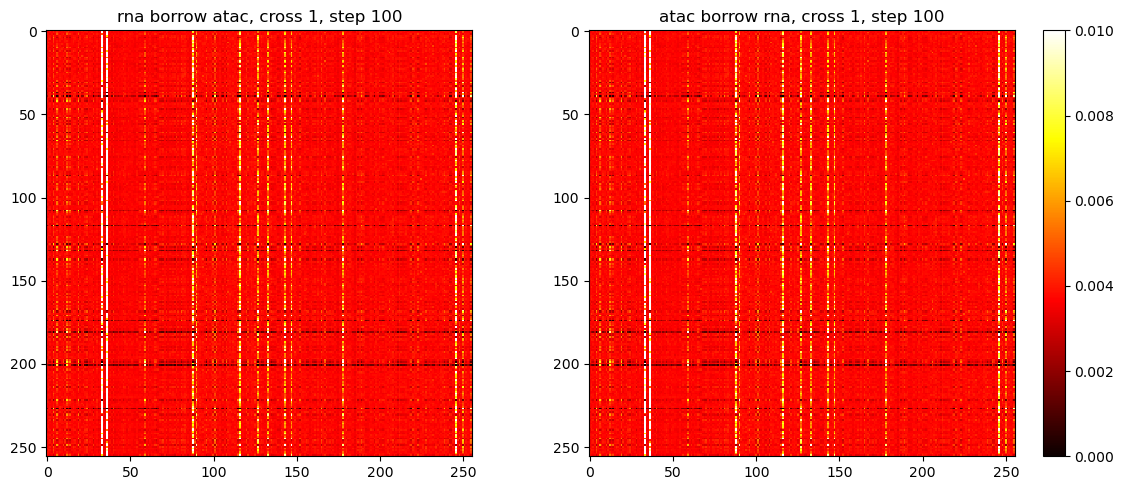

(128, 128)


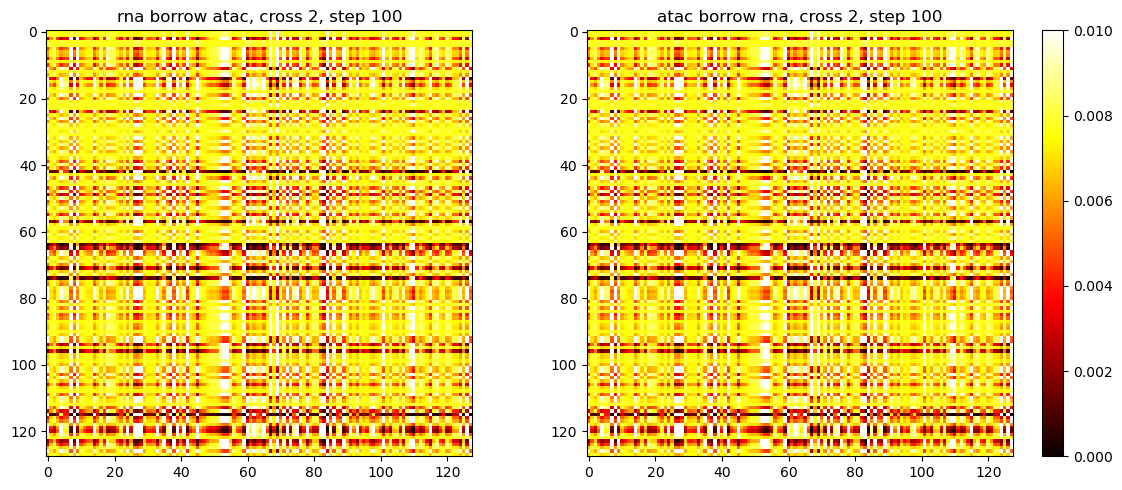

(256, 256)


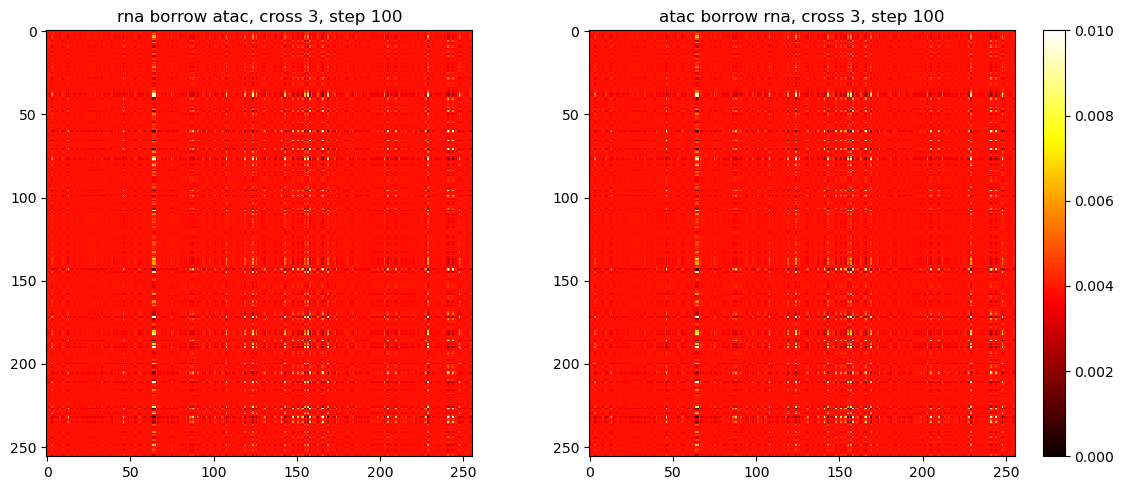

(256, 256)


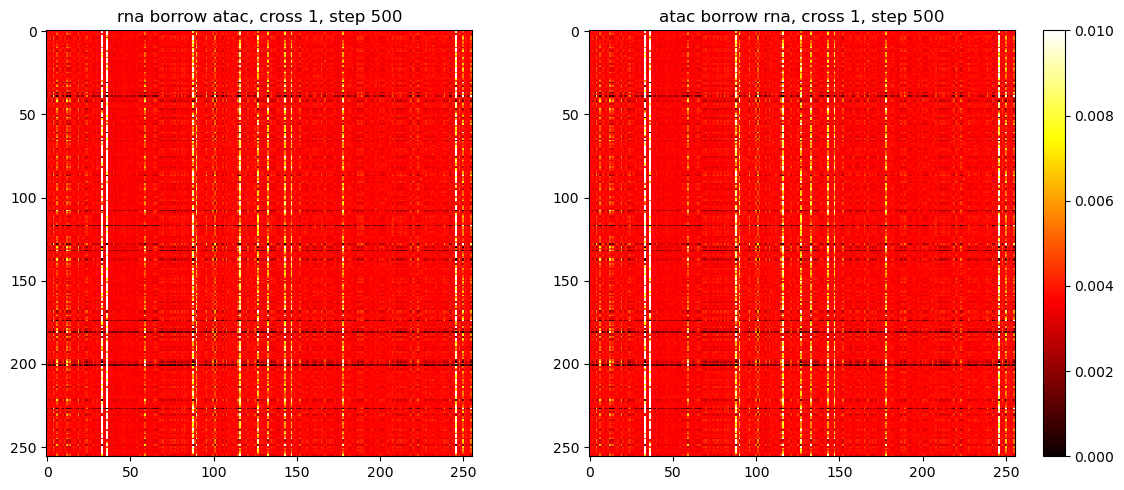

(128, 128)


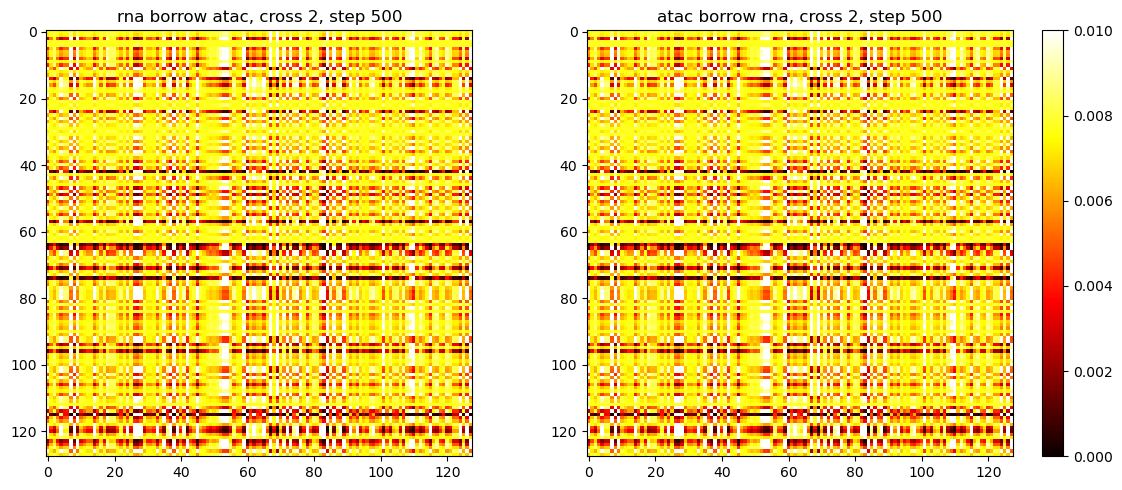

(256, 256)


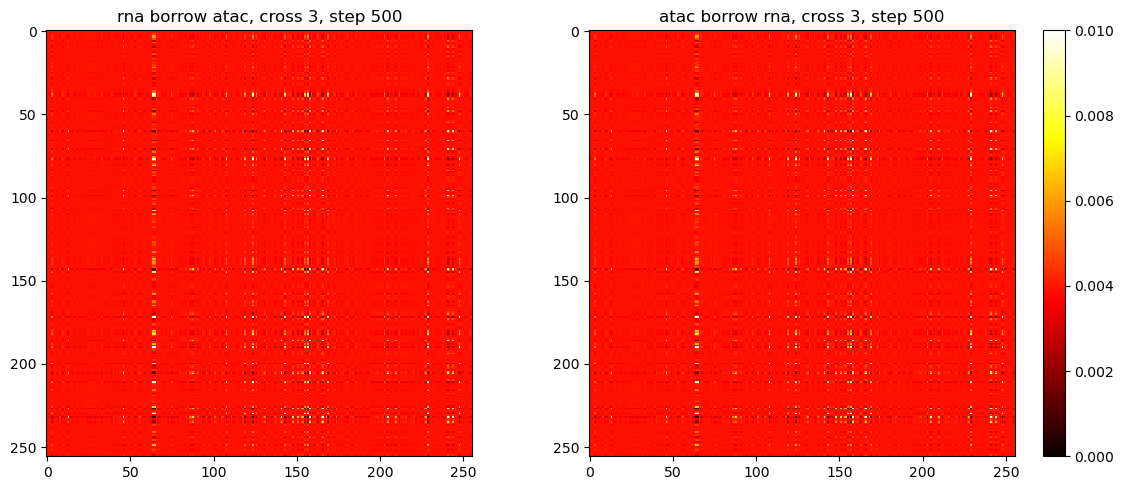

(256, 256)


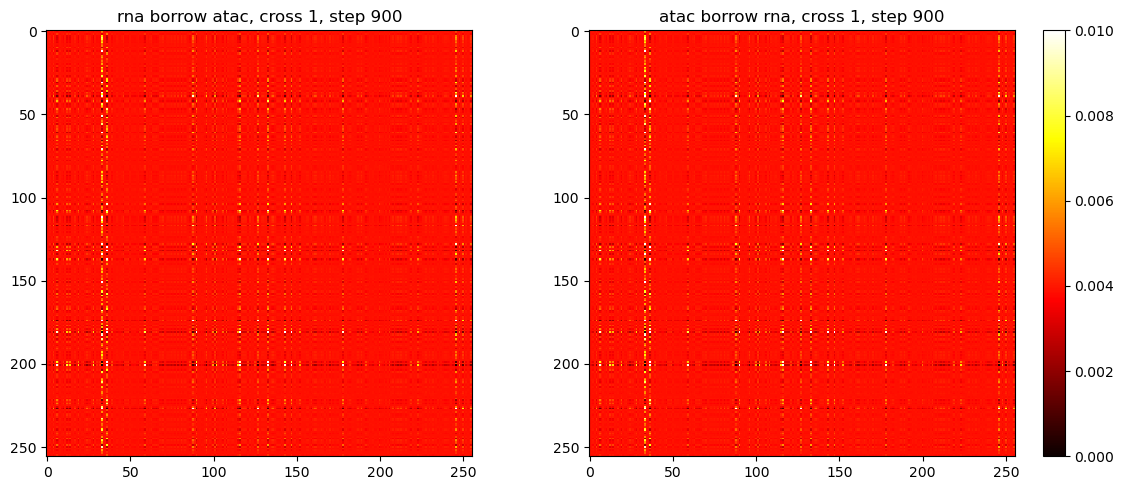

(128, 128)


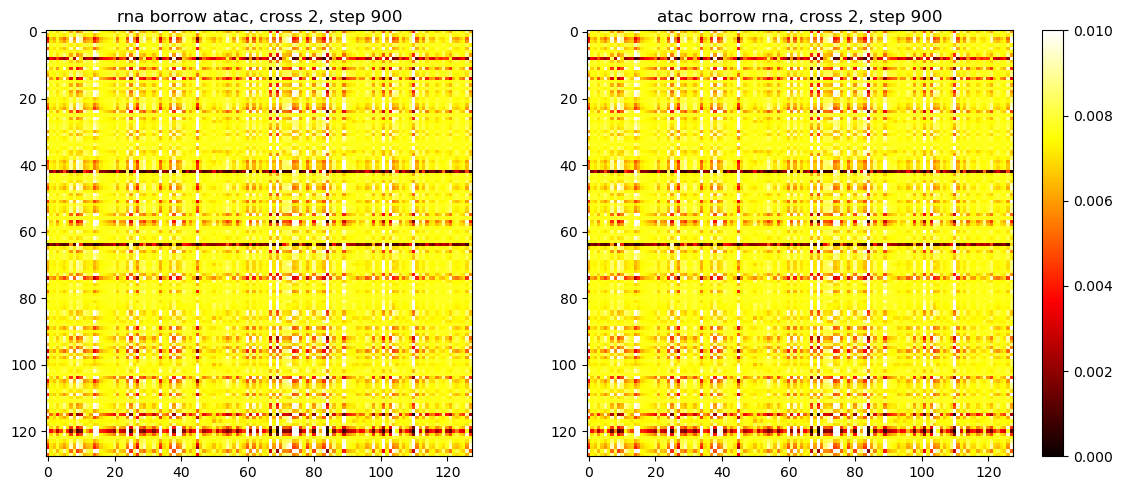

(256, 256)


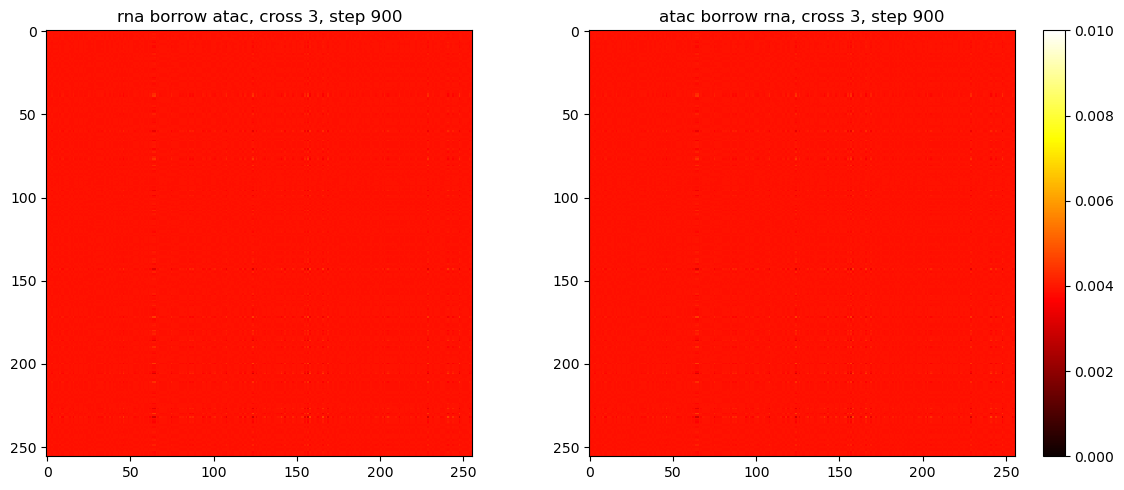

In [ ]:
for step in [100,500,900]:
    for i in [1,2,3]:
        arr_rna = np.load(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/attention_map/condition_type14_open/att_map_rna_{i}_step{step}.npz')['data']
        arr_atac = np.load(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/attention_map/condition_type14_open/att_map_rna_{i}_step{step}.npz')['data']
        print(arr_rna.shape)
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['ps.fonttype'] = 42
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        # 在第一个子图上绘制第一个热力图
        # sns.heatmap(arr_rna, annot=True, cmap='coolwarm', ax=ax1, vmax=0.01,vmin=0.0)
        cax = ax1.imshow(arr_rna, interpolation='nearest', cmap='hot', vmin=0, vmax=0.01)
        ax1.set_title(f'rna borrow atac, cross {i}, step {step}')

        # 在第二个子图上绘制第二个热力图
        # sns.heatmap(arr_atac, annot=True, cmap='coolwarm', ax=ax2, vmax=0.01,vmin=0.0)
        cax = ax2.imshow(arr_atac, interpolation='nearest', cmap='hot', vmin=0, vmax=0.01)
        ax2.set_title(f'atac borrow rna, cross {i}, step {step}')

        # 调整子图之间的间距
        plt.tight_layout()
        fig.colorbar(cax)

        # 显示图表
        plt.show()
        # break

information entropy with time step

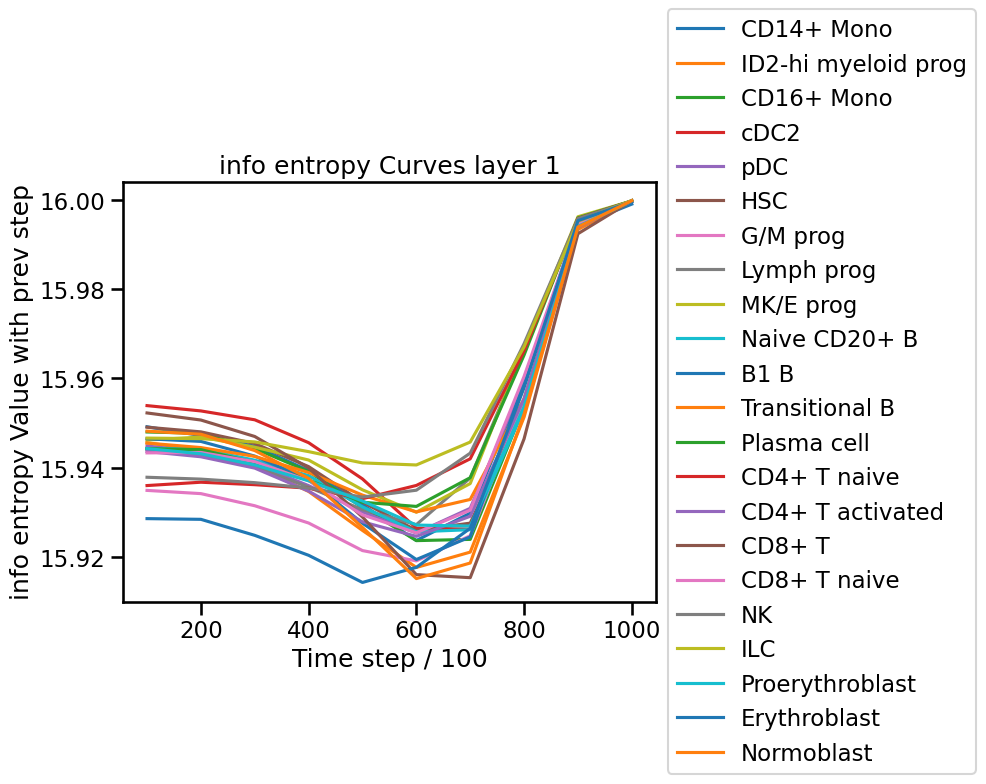

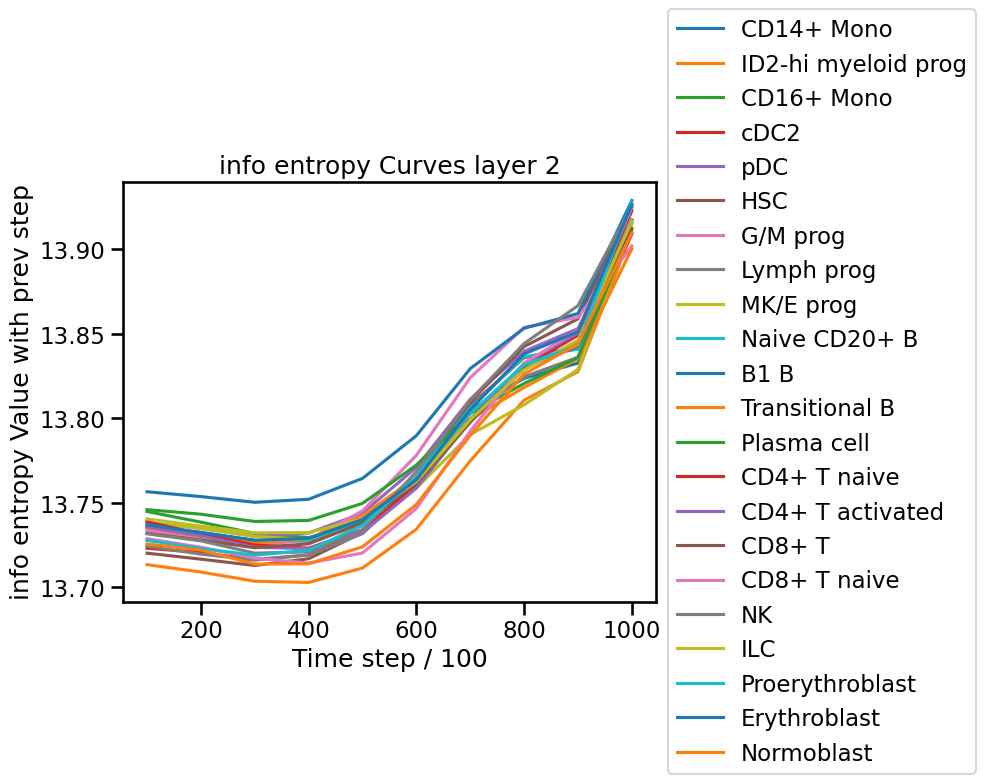

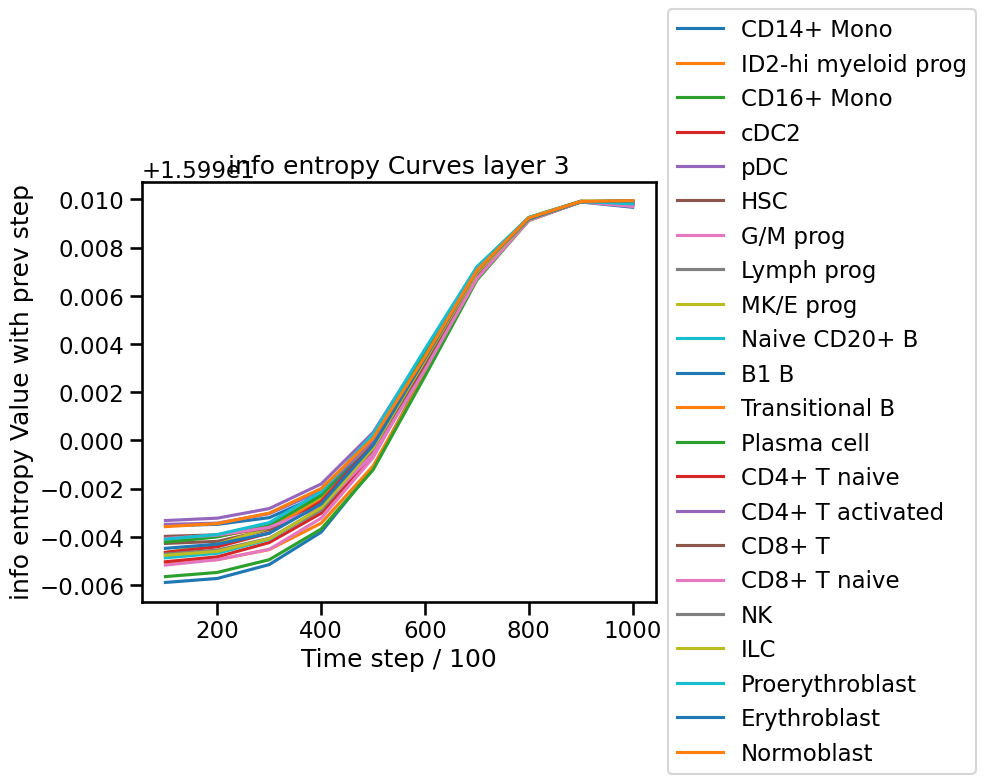

In [46]:
root_dir = '/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/attention_map'
all_map_path = os.listdir(root_dir)
for layer in [1,2,3]:
    att_all_t_c = []
    for step in list(range(100,1001,100)):
        att_all_t = []
        for folder in all_map_path[1:]:
            target_map = f'att_map_atac_{layer}_step{str(step)}.npz'
            arr = np.load(os.path.join(root_dir,folder,target_map))['data']
            att_all_t.append(arr)
        att_all_t = np.stack(att_all_t)
        att_all_t_c.append(att_all_t)
    att_all_t_c = np.stack(att_all_t_c)

    average_entropy = calculate_entropies(att_all_t_c)
    plot_mse_curves(average_entropy.T, type_list, list(range(100,1001,100)),str(layer),'info entropy')

mse with time step

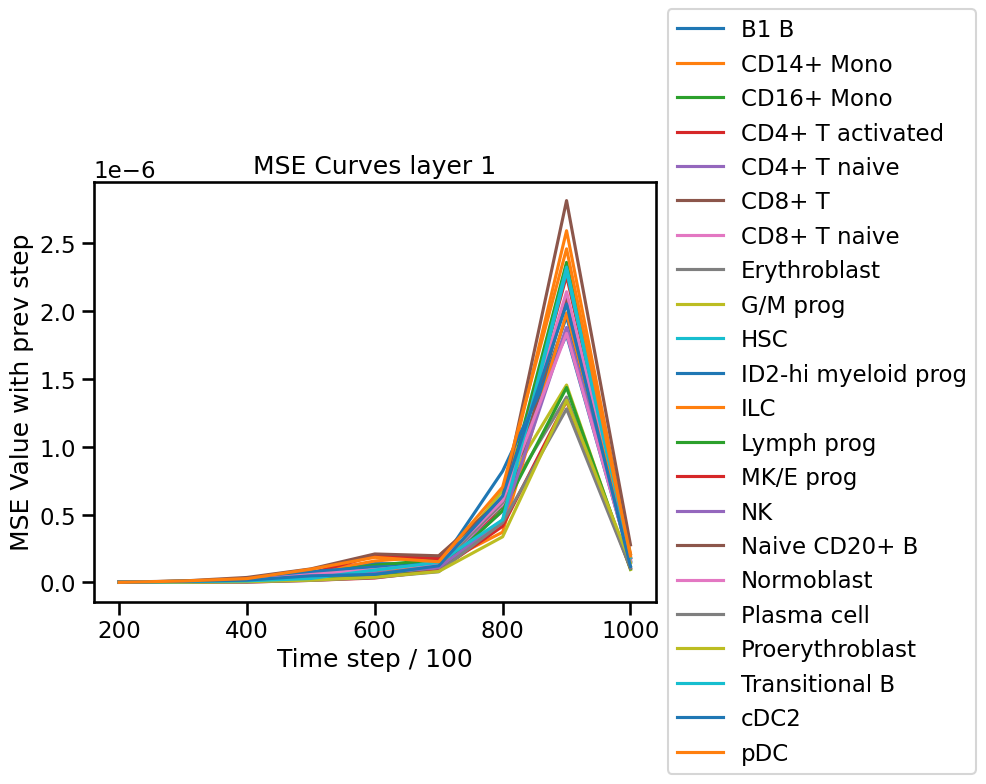

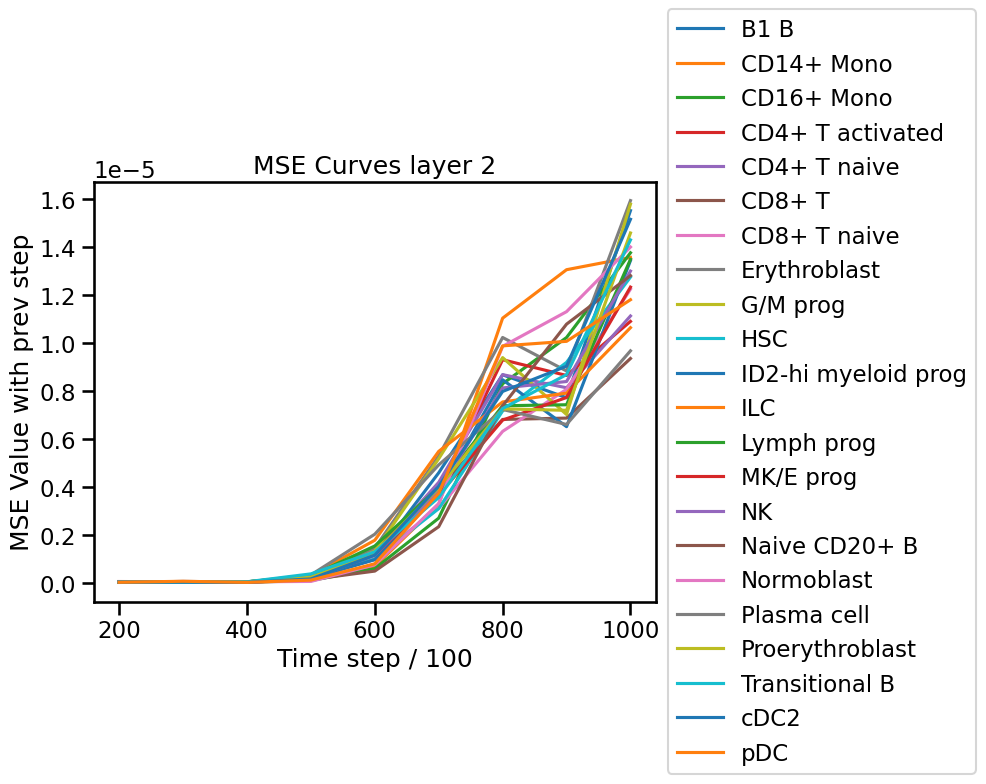

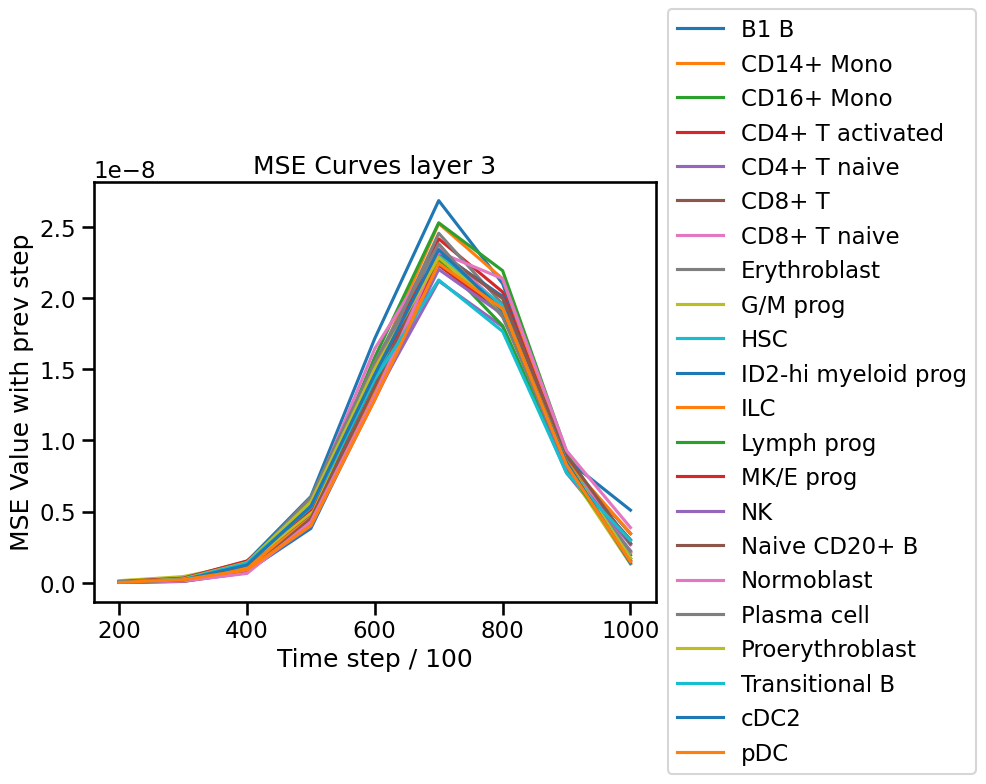

In [4]:
root_dir = '/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/attention_map'
all_map_path = os.listdir(root_dir)
for layer in [1,2,3]:
    att_all_t_c = []
    for step in list(range(100,1001,100)):
        att_all_t = []
        for folder in all_map_path[1:]:
            target_map = f'att_map_atac_{layer}_step{str(step)}.npz'
            arr = np.load(os.path.join(root_dir,folder,target_map))['data']
            att_all_t.append(arr)
        att_all_t = np.stack(att_all_t)
        att_all_t_c.append(att_all_t)
    att_all_t_c = np.stack(att_all_t_c)

    mse = calculate_mse(att_all_t_c)
    plot_mse_curves(mse.T, type_list, list(range(200,1001,100)),str(layer), 'MSE')

attention map for different cell types

In [113]:
# 检验cell type间的var和cell type内的var
target_map = 'att_map_atac_2_step950_all.npz'
root_dir = '/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/attention_map'
all_map_path = os.listdir(root_dir)
att_all = []
for folder in all_map_path[1:]:
    arr = np.load(os.path.join(root_dir,folder,target_map))['data']
    att_all.append(arr)
att_all = np.stack(att_all)

In [44]:
# 同一个batch内多种cell type
att_all = []
index_type = np.load('/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/attention_map_open_all/type.npz')['data']
att = np.load('/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/attention_map_open_all/condition_type0_open/att_map_atac_2_step950_all.npz')['data']
for i in np.unique(index_type):
    att_all.append(att[index_type==i])


variance within and between cell type

In [46]:
# 同一个batch内多种cell type
att_cell_type = []
for i in range(len(att_all)):
    print(att_all[i].var(0).mean(-1).mean(-1))
    att_cell_type.append(att_all[i].mean(0))

print(np.stack(att_cell_type).var(0).mean())

2.1783444e-05
1.7584936e-05
1.4384159e-05
1.8907078e-05
1.7967966e-05
1.8962943e-05
1.7558188e-05
2.0558835e-05
2.3817505e-05
1.7178787e-05
1.2701071e-05
1.3198092e-05
1.47754345e-05
2.6022757e-05
2.0492877e-05
2.0318283e-05
1.3841667e-05
5.8764676e-06
1.84887e-05
1.4020162e-05
1.8062434e-05
1.7068758e-05
3.0709475e-06


In [114]:
att_all.shape

(22, 500, 128, 128)

In [115]:
# within cell type                               between cell type
att_all[:,:22].var(1).mean(-1).mean(-1), att_all.mean(1).var(0).mean()

(array([2.0816798e-05, 2.4335768e-05, 1.6271608e-05, 1.3657605e-05,
        1.4754511e-05, 1.3351105e-05, 1.8401228e-05, 1.6567206e-05,
        1.5891903e-05, 1.3964631e-05, 9.7266857e-06, 1.5931528e-05,
        1.6539954e-05, 1.5273550e-05, 1.5770151e-05, 1.6113720e-05,
        1.4651961e-05, 1.0671143e-05, 2.4664607e-05, 1.4520365e-05,
        1.6852726e-05, 1.5077298e-05], dtype=float32),
 2.2238048e-06)

In [63]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
import numpy as np

# Assuming `data` is your dataset (numpy array or pandas dataframe) and `n_clusters` is the number of clusters
n_clusters =14#22
data = att_all[:,:22]
# # Step 1: Fit KMeans (or another clustering algorithm) to obtain cluster labels and centroids
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# kmeans.fit(data)
# labels = kmeans.labels_
# centroids = kmeans.cluster_centers_

# Step 2: Calculate within-cluster distances (distance of points to their respective centroid)
bs = data.shape[1]
centroids_all = []
within_cluster_distances = []
for i in range(n_clusters):
    cluster_points = data[i].reshape(bs,-1)
    kmeans = KMeans(n_clusters=1, random_state=42, n_init='auto')
    kmeans.fit(data[i].reshape(bs,-1))
    centroids = kmeans.cluster_centers_
    centroids_all.append(centroids[0])
    centroid = centroids[0].reshape(1, -1)
    distances = pairwise_distances(cluster_points, centroid).flatten()
    within_cluster_distances.extend(distances)

# Mean and variance of within-cluster distances
mean_within_cluster_distance = np.mean(within_cluster_distances)
var_within_cluster_distance = np.var(within_cluster_distances)

# Step 3: Calculate between-cluster distances (pairwise distances between cluster centroids)
centroids_all = np.stack(centroids_all)
between_cluster_distances = pairwise_distances(centroids_all)
# Take only the upper triangle, as distance matrix is symmetric
between_cluster_distances = between_cluster_distances[np.triu_indices(n_clusters, k=1)]

# Mean and variance of between-cluster distances
mean_between_cluster_distance = np.mean(between_cluster_distances)
var_between_cluster_distance = np.var(between_cluster_distances)

# Display results
print(f"Mean Within-Cluster Distance: {mean_within_cluster_distance}")
print(f"Variance of Within-Cluster Distance: {var_within_cluster_distance}")
print(f"Mean Between-Cluster Distance: {mean_between_cluster_distance}")
print(f"Variance of Between-Cluster Distance: {var_between_cluster_distance}")

# Optional: comparison ratios
mean_ratio = mean_within_cluster_distance / mean_between_cluster_distance
variance_ratio = var_within_cluster_distance / var_between_cluster_distance

print(f"Mean Distance Ratio (Within / Between): {mean_ratio}")
print(f"Variance Ratio (Within / Between): {variance_ratio}")


Mean Within-Cluster Distance: 0.4840182065963745
Variance of Within-Cluster Distance: 0.02960720844566822
Mean Between-Cluster Distance: 0.30201059579849243
Variance of Between-Cluster Distance: 0.006670491304248571
Mean Distance Ratio (Within / Between): 1.6026530265808105
Variance Ratio (Within / Between): 4.438534736633301


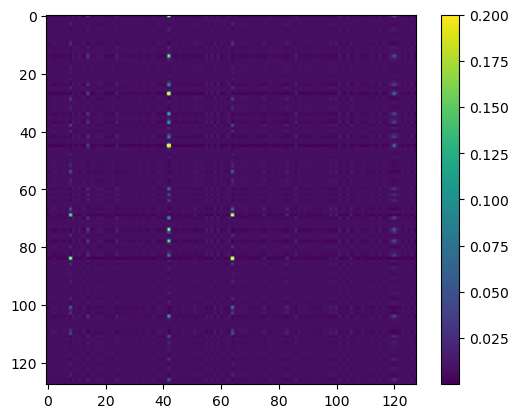

In [116]:
plt.imshow(att_all[2,160], vmax=0.2)
plt.colorbar()

# element wise feature selection

In [194]:
# 针对某个具体的step，看key element
# avarage
target_map = 'att_map_atac_2_step950.npz'
root_dir = '/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/attention_map'
all_map_path = os.listdir(root_dir)
att_all = []
for folder in all_map_path[1:]:
    arr = np.load(os.path.join(root_dir,folder,target_map))['data']
    # fig = plt.figure(figsize=(12, 5))
    # cax = plt.imshow(abs(arr), interpolation='nearest', cmap='hot', vmin=0, vmax=0.01)
    # fig.colorbar(cax)
    att_all.append(arr)
att_all = np.stack(att_all)
variance = np.var(att_all, axis=0)
mean = np.mean(att_all, axis=0)
std_dev = np.sqrt(variance)
# 标准化为 z-score: (x - mean) / std
z_score_normalized_data = (att_all - mean) / std_dev
print(z_score_normalized_data.shape) 

(22, 128, 128)


In [77]:
key_set2 = {}
for i in range(22):
    # important_atac, important_rna = find_max_index(z_score_normalized_data[i],20)
    important_rna = np.argsort(z_score_normalized_data[i].sum(1))[-20:][::-1]
    key_set2[type_list[i]] = important_rna
    print(f'{type_list[i]} key elements set: ', important_rna)

B1 B key elements set:  [ 81  89 127  73  50  52 116  36  16 103 112 124  76  93  87  38  55  19
  22  48]
CD14+ Mono key elements set:  [ 27 104   2 123  35  91  70  99  29 121  46 110  17  38  96   3  59 101
   7 108]
CD16+ Mono key elements set:  [ 74 104 119 127 123  27  35 101  91 110  24  31  54  96  88  99  75  81
   3 109]
CD4+ T activated key elements set:  [ 14 119  81  42  36  60 127  64  62  95 126   5   6  85  65 115 109 108
  83   1]
CD4+ T naive key elements set:  [ 81  27   0  14  42 104  36  37   6  60  69  29 119  67  11  54  76 113
   5  38]
CD8+ T key elements set:  [ 45  27  14  70  42  81 119  36  64 126  89  62  40   0  54 107  35  68
   6  74]
CD8+ T naive key elements set:  [ 84  37  81 104  78 111  42  39  26  36  69  64  60  45  38  80   8  76
 123   5]
Erythroblast key elements set:  [ 11  60  39  34 104  67  37 111  24  15  91  69  82 113 110   2  92  26
 119  21]
G/M prog key elements set:  [ 21 104  81 119  24  46  50  15  52  62 113  85  96  35  59  34  

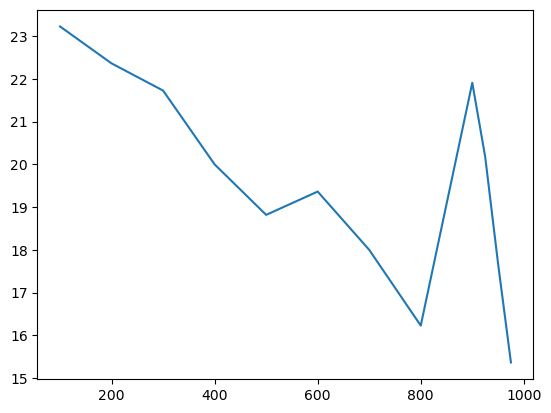

In [7]:
# 找到每个step下，每个cell type中，z score map在列求和下最大的列，并求这些列和下一个时间点的列的交集长度

key_in_diff_step = []
steps = [100,200,300,400,500,600,700,800,900,925,950,975,1000]
for step in steps:
    # avarage
    target_map = f'att_map_atac_2_step{str(step)}.npz'
    root_dir = '/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/attention_map'
    all_map_path = os.listdir(root_dir)
    att_all = []
    for folder in all_map_path[1:]:
        arr = np.load(os.path.join(root_dir,folder,target_map))['data']
        att_all.append(arr)
    att_all = np.stack(att_all)
    # print(att_all.var(0).mean())
    variance = np.var(att_all, axis=0)
    mean = np.mean(att_all, axis=0)
    std_dev = np.sqrt(variance)
    # 标准化为 z-score: (x - mean) / std
    z_score_normalized_data = (att_all - mean) / std_dev

    key_set = {}
    for i in range(22):
        important_rna = np.argsort(z_score_normalized_data[i].sum(1))[-25:][::-1]
        # important_atac, important_rna = find_max_index(z_score_normalized_data[i],20)
        key_set[type_list[i]] = important_rna
    key_in_diff_step.append(key_set)

over_nums = []
for i in range(len(key_in_diff_step[:-1])):
    over_num = []
    for key in key_in_diff_step[i].keys():
        over_num.append(np.intersect1d(key_in_diff_step[i][key],key_in_diff_step[i+1][key]).shape[0])
    over_nums.append(np.mean(over_num))

plt.plot(steps[:-1],over_nums)

In [8]:
# 找到每个step下，每个cell type中，z score map在列求和下最大的列，并求每个cell type下，所有时间步下列的交集

common_ele_all = {}
for key in key_in_diff_step[0].keys():
    common_elements = key_in_diff_step[7][key]
    for arr in key_in_diff_step[8:]:

        common_elements = np.intersect1d(common_elements, arr[key])
    
    common_ele_all[key] = common_elements
    print(f'common elements of {key} are: ', common_elements)

common elements of B1 B are:  [ 50  87  89 116]
common elements of CD14+ Mono are:  [  2  29 104 123]
common elements of CD16+ Mono are:  [ 31  74  91 104 123]
common elements of CD4+ T activated are:  [36 60 65 81]
common elements of CD4+ T naive are:  [  0  14  27  37  54  60  81 104]
common elements of CD8+ T are:  [14 27 45 70]
common elements of CD8+ T naive are:  [ 26  37  39  78  80  81 104]
common elements of Erythroblast are:  [ 11  67  82 104 113]
common elements of G/M prog are:  [ 15  21  37  62 104]
common elements of HSC are:  [15 21 24 56 70 83 84]
common elements of ID2-hi myeloid prog are:  [  0  27  34  39  54  75  83 101 104]
common elements of ILC are:  [ 25  27  29  34  37  78 104]
common elements of Lymph prog are:  [ 15  62  64  73 115]
common elements of MK/E prog are:  [21 45 73 84 89]
common elements of NK are:  [27 69 91]
common elements of Naive CD20+ B are:  [38 73 89]
common elements of Normoblast are:  [  0   9  25  38  70  84 101 103 119]
common elements

/tmp/ipykernel_3593826/1504550448.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 5))


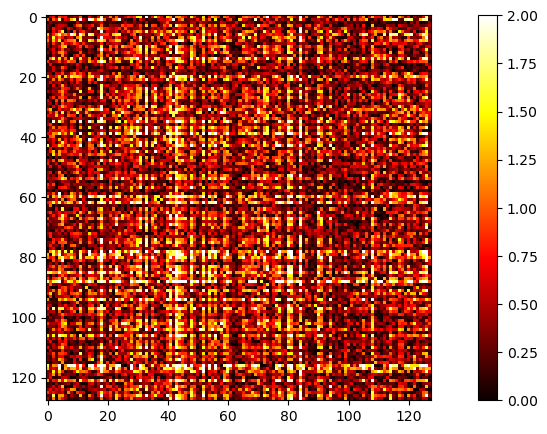

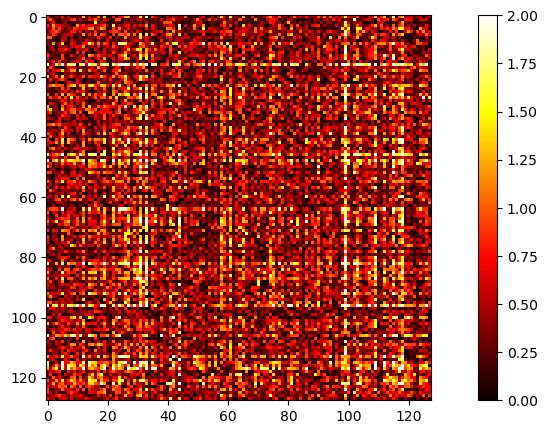

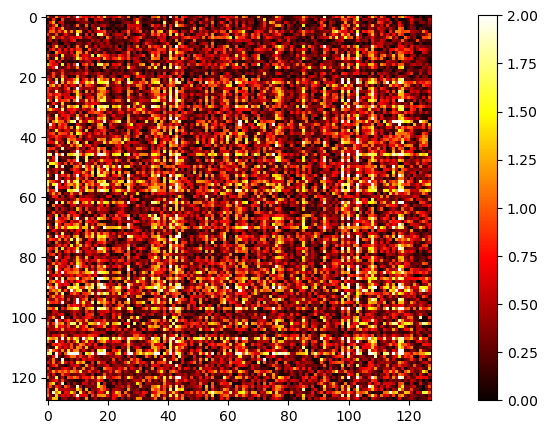

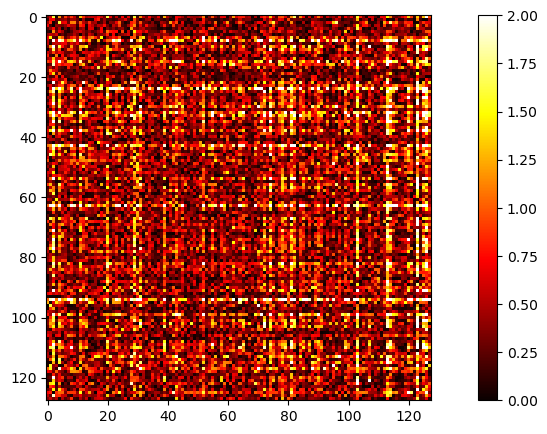

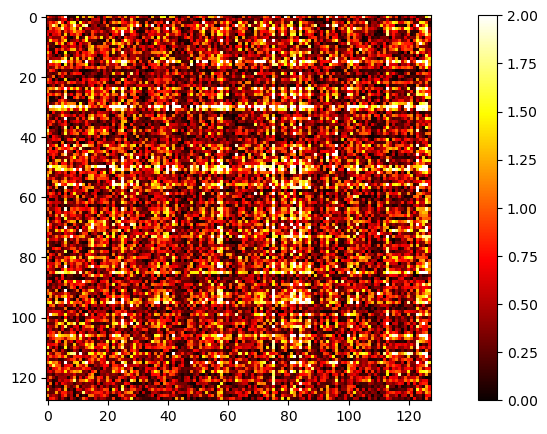

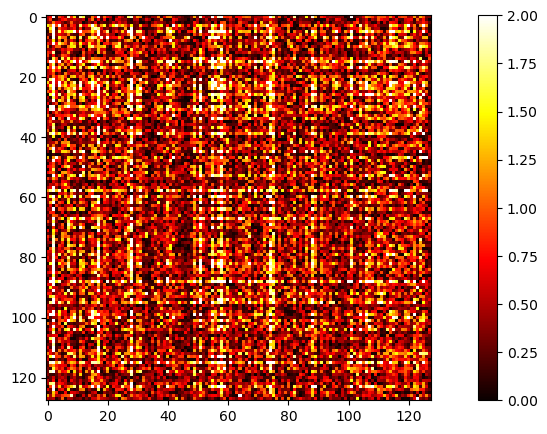

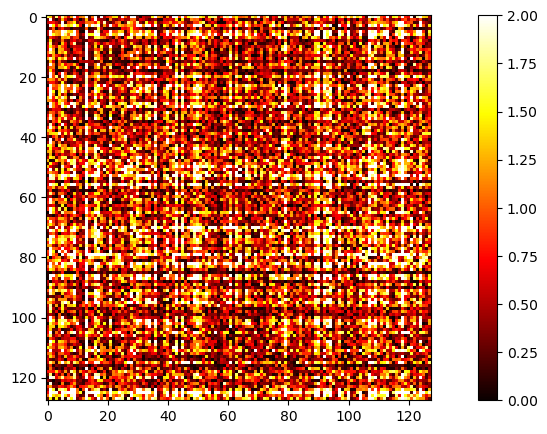

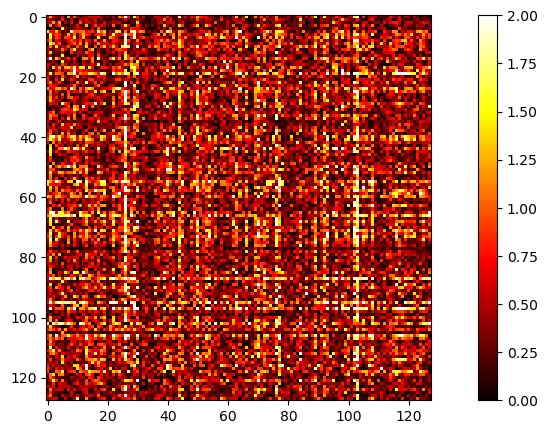

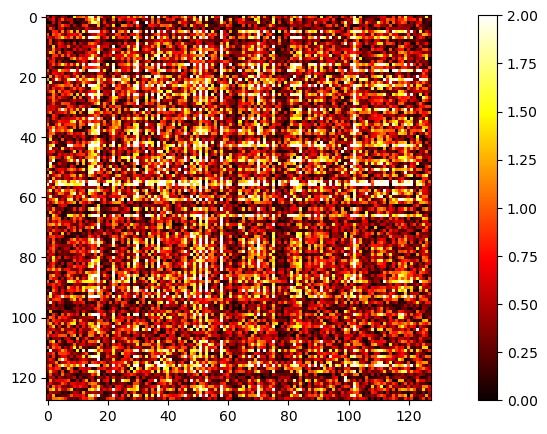

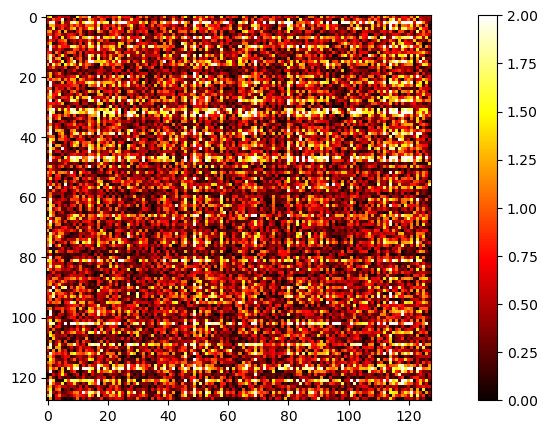

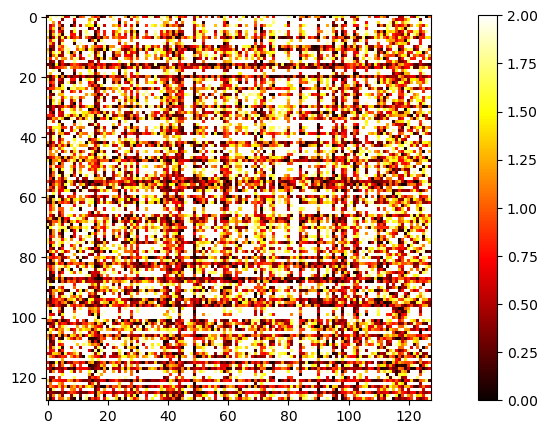

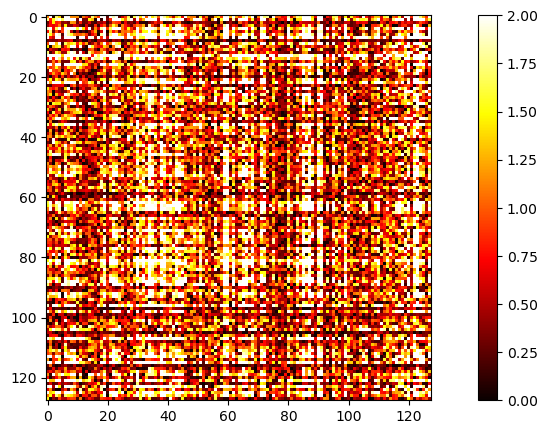

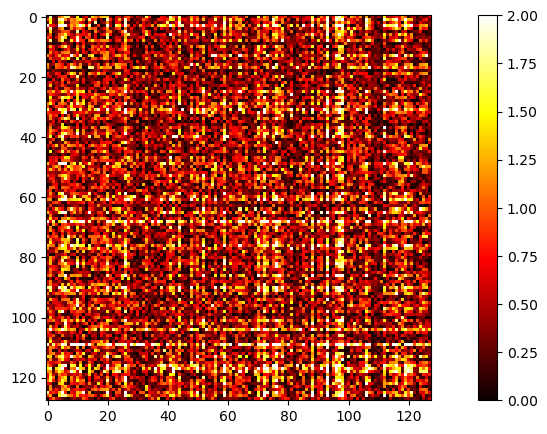

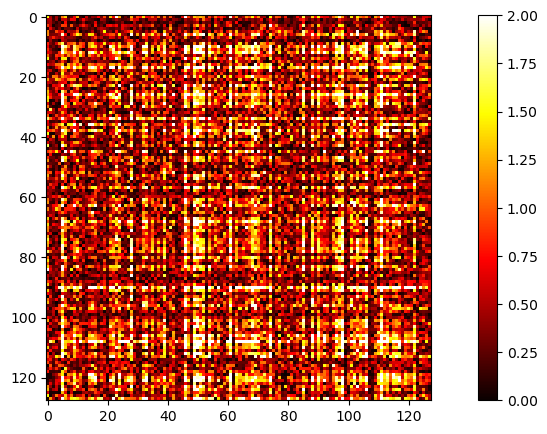

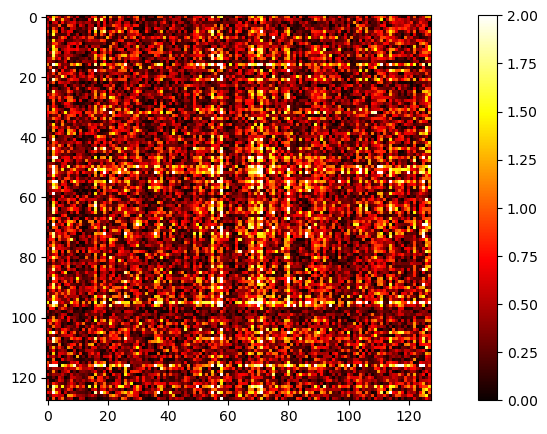

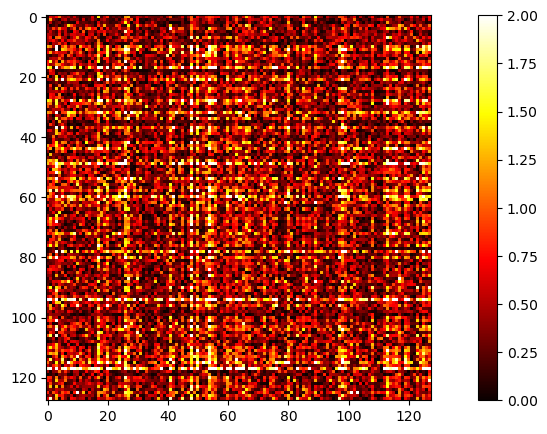

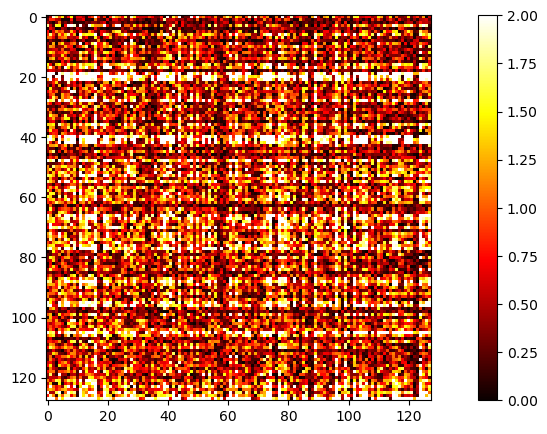

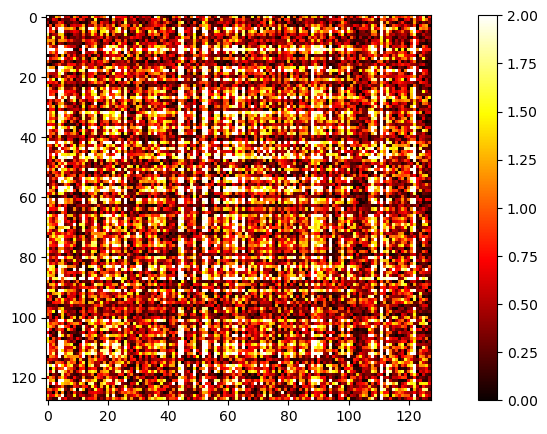

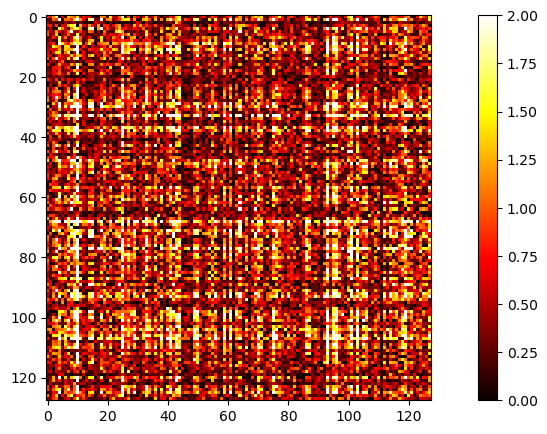

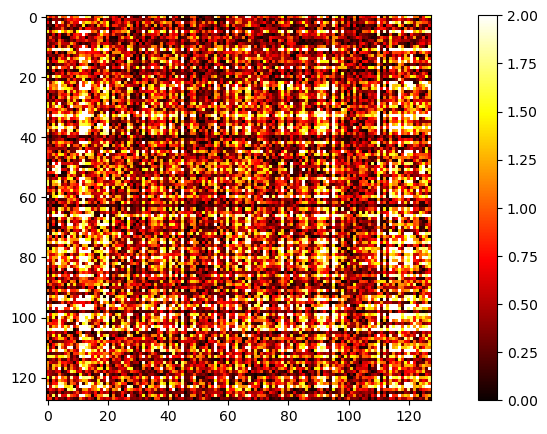

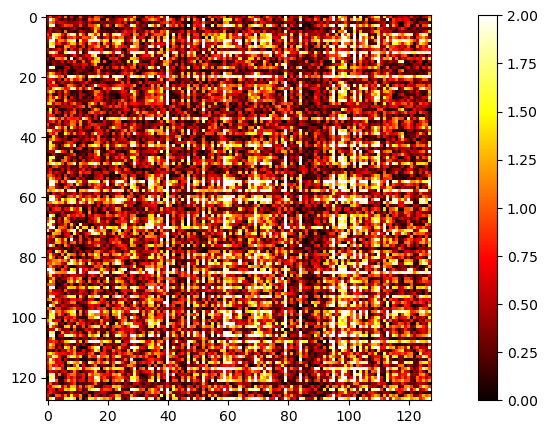

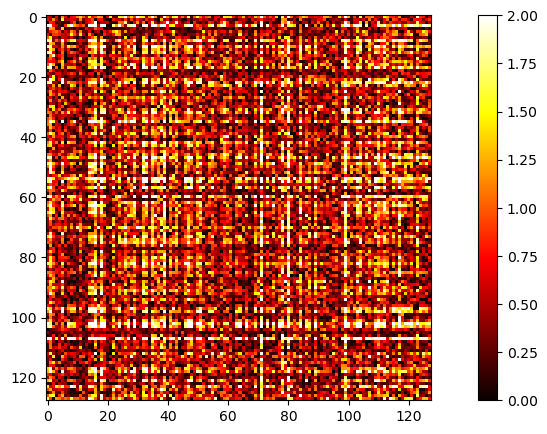

In [ ]:
for i in range(z_score_normalized_data.shape[0]):
    fig = plt.figure(figsize=(12, 5))
    cax = plt.imshow(abs(z_score_normalized_data[i]), interpolation='nearest', cmap='hot', vmin=0, vmax=2)
    fig.colorbar(cax)

# 从training samples出发算attention map

load autoencoder and diffusion model

In [27]:
encoder_config = "encoder_multimodal"
dataset_path = '/stor/lep/diffusion/multiome/openproblem_filtered.h5mu'#"/stor/lep/data/BABEL/all.h5mu"
covariate_keys = "cell_type" #"leiden"
num_class = 22 #33
# ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_babel_multimodal/checkpoints/epoch_39.ckpt"
ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal/checkpoints/last.ckpt"

In [28]:
mdata = mu.read_h5mu(dataset_path)
real_cell = mdata['rna'][::5].X.toarray()
real_cell2 = mdata['atac'][::5].X.toarray()
# real_cell = mdata['rna'][mdata['rna'].obs['cell_type']=='CD4+ T activated'].X.toarray()[::7]
# real_cell2 = mdata['atac'][mdata['atac'].obs['cell_type']=='CD4+ T activated'].X.toarray()[::7]
real_cell.shape

(13850, 13431)

In [29]:
with open(f'{os.getcwd()}/../../CFGen/configs/configs_encoder/encoder/{encoder_config}.yaml', 'r') as file:
    yaml_content = file.read()
autoencoder_args = yaml.safe_load(yaml_content)
autoencoder_args['encoder_kwargs']['rna']['norm_type']='batchnorm'
autoencoder_args['encoder_kwargs']['atac']['norm_type']='batchnorm'

# Initialize encoder                'atac': 143810, 'rna': 19448
encoder_model = EncoderModel(in_dim={'atac': real_cell2.shape[1], 'rna': real_cell.shape[1]},
                                    n_cat=mdata['rna'].obs[covariate_keys].unique().shape[0],
                                    conditioning_covariate=covariate_keys, 
                                    encoder_type='learnt_autoencoder',
                                    **autoencoder_args)

# Load weights 
# encoder_model.load_state_dict(torch.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal_fixed/checkpoints/last.ckpt')["state_dict"])
encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])
optimizer = optim.Adam(encoder_model.parameters(), lr=0.001)
# encoder_model.eval()

In [30]:
defaults = dict(
    clip_denoised=True,
    ref_path="",
    batch_size=16,
    sample_fn="dpm_solver",
    sr_sample_fn="dpm_solver",
    sr_model_path="",
    multimodal_model_path="",
    output_dir="",
    save_type="mp4",
    classifier_scale=0,
    devices=None,
    is_strict=True,
    all_save_num= 1024,
    seed=42,
    video_fps=10,
    audio_fps=16000,
    load_noise="",
    use_cfgen=False,
    data_dir="",
    condition='cell_type',
)
defaults.update(model_and_diffusion_defaults())
parser = argparse.ArgumentParser()
defaults['cross_attention_resolutions'] = '2,4,8'
defaults['cross_attention_windows'] = '1,4,8'
defaults['cross_attention_shift'] = True
defaults['video_attention_resolutions'] = '-1'
defaults['audio_attention_resolutions'] = '-1'
defaults['use_cfgen'] = True
defaults['video_size'] = '1,100'
defaults['audio_size'] = '1,100'
defaults['learn_sigma'] = False
defaults['num_channels'] = 128
defaults['num_head_channels'] = -1
defaults['num_res_blocks'] = 1
defaults['resblock_updown'] = True
defaults['use_fp16'] = False
defaults['use_scale_shift_norm'] = True
defaults['num_class'] = 22
defaults['class_cond'] = True
defaults['condition'] = 'cell_type'
defaults['diffusion_steps'] = 1000
defaults['noise_schedule'] = 'linear'
defaults['all_save_num'] = 500
defaults['save_type'] = 'mp4'
defaults['devices'] = '0'
defaults['batch_size'] = 500
defaults['is_strict'] = True
defaults['sample_fn'] = 'ddim'
defaults['output_dir'] = 'test'
defaults['multimodal_model_path'] = '/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/checkpoints_cross/open_lr1e4_w512_scale124_drop0_80w_rescale10_3crossatt64_condi/model800000.pt'
defaults['data_dir'] = '/stor/lep/diffusion/multiome/openproblem_filtered.h5mu'
add_dict_to_argparser(parser, defaults)

In [31]:
args = parser.parse_known_args()[0]
args.video_size = [int(i) for i in args.video_size.split(',')]
args.audio_size = [int(i) for i in args.audio_size.split(',')]

dist_util.setup_dist(args.devices)

print("creating model and diffusion...")
multimodal_model, multimodal_diffusion = create_model_and_diffusion(
        **args_to_dict(args, [key for key in model_and_diffusion_defaults().keys()])
)
multimodal_model.load_state_dict_(
        dist_util.load_state_dict(args.multimodal_model_path, map_location="cpu"), is_strict=args.is_strict
)
multimodal_model.to(dist_util.dev())
optimizer2 = optim.Adam(multimodal_model.parameters(), lr=0.001)

# mdata = mu.read_h5mu(args.data_dir)
from sklearn.preprocessing import LabelEncoder
labels = mdata['rna'].obs[args.condition].values
label_encoder = LabelEncoder()
label_encoder.fit(labels)
classes_all = label_encoder.transform(labels)

rna = mdata['rna']#[mdata['rna'].obs['cell_type']=='Erythroblast']
atac = mdata['atac']#[mdata['atac'].obs['cell_type']=='Erythroblast']

0
creating model and diffusion...


In [32]:
time_step = 1
down_sample = 2
model_kwargs = {}
batch = {}

x1 = torch.tensor(rna[::down_sample].X.toarray(),requires_grad=True)
x2 = torch.tensor(atac[::down_sample].X.toarray(),requires_grad=True)

batch["X_norm"] = {'rna':x1,'atac':x2}
z = encoder_model.encode(batch)
video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())

noise ={"video":torch.randn_like(video_start),\
    "audio":torch.randn_like(audio_start)}

#0 means t_th step, 1 means the audio gives groundtruth, 2 means the video gives the groundtruth
# condition_index = x_start["condition"]  
t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])#.detach()
audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])#.detach()

att_layer1 = []
att_layer1_atac = []
att_layer2 = []
att_layer2_atac = []
att_layer3 = []
att_layer3_atac = []
for celltype in type_list:
    index = (rna[::down_sample].obs['cell_type'] == celltype)
    # sample_id = np.random.choice(np.arange(0, index.sum()), size=22, replace=False)
    video_t_i = video_t[index][:10000]#[sample_id]
    audio_t_i = audio_t[index][:10000]#[sample_id]
    t_i = t[index][:10000]#[sample_id]
    labels = model_kwargs["label"][index][:10000]#[sample_id]

    noise_pred_video, noise_pred_video, att_maps = multimodal_model(video_t_i,audio_t_i,t_i,labels,return_attvec=True)
    att_layer1.append(att_maps[3])
    att_layer2.append(att_maps[7])
    att_layer3.append(att_maps[11])
    att_layer1_atac.append(att_maps[2])
    att_layer2_atac.append(att_maps[6])
    att_layer3_atac.append(att_maps[10])

算指标，celltype variance

In [ ]:
# 同一个batch内多种cell type
att_cell_type = []
for i in range(len(att_layer2)):
    print(att_layer2[i].var(0).mean(-1).mean(-1))
    att_cell_type.append(att_layer2[i].mean(0))

print(torch.stack(att_cell_type).var(0).mean())

tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0059, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0064, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0063, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0061, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0062, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0060, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0065, device='cuda:0', grad_fn=<MeanBackward1>)
tensor(0.0062, device='cuda:0',

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
import numpy as np

# Assuming `data` is your dataset (numpy array or pandas dataframe) and `n_clusters` is the number of clusters
n_clusters =22#14
data = att_layer2
# # Step 1: Fit KMeans (or another clustering algorithm) to obtain cluster labels and centroids
# kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# kmeans.fit(data)
# labels = kmeans.labels_
# centroids = kmeans.cluster_centers_

# Step 2: Calculate within-cluster distances (distance of points to their respective centroid)

centroids_all = []
within_cluster_distances = []
for i in range(n_clusters):
    bs = data[i].shape[0]
    cluster_points = data[i].reshape(bs,-1).detach().cpu().numpy()
    kmeans = KMeans(n_clusters=1, random_state=42, n_init='auto')
    kmeans.fit(data[i].reshape(bs,-1).detach().cpu().numpy())
    centroids = kmeans.cluster_centers_
    centroids_all.append(centroids[0])
    centroid = centroids[0].reshape(1, -1)
    distances = pairwise_distances(cluster_points, centroid).flatten()
    within_cluster_distances.extend(distances)

# Mean and variance of within-cluster distances
mean_within_cluster_distance = np.mean(within_cluster_distances)
var_within_cluster_distance = np.var(within_cluster_distances)

# Step 3: Calculate between-cluster distances (pairwise distances between cluster centroids)
centroids_all = np.stack(centroids_all)
between_cluster_distances = pairwise_distances(centroids_all)
# Take only the upper triangle, as distance matrix is symmetric
between_cluster_distances = between_cluster_distances[np.triu_indices(n_clusters, k=1)]

# Mean and variance of between-cluster distances
mean_between_cluster_distance = np.mean(between_cluster_distances)
var_between_cluster_distance = np.var(between_cluster_distances)

# Display results
print(f"Mean Within-Cluster Distance: {mean_within_cluster_distance}")
print(f"Variance of Within-Cluster Distance: {var_within_cluster_distance}")
print(f"Mean Between-Cluster Distance: {mean_between_cluster_distance}")
print(f"Variance of Between-Cluster Distance: {var_between_cluster_distance}")

# Optional: comparison ratios
mean_ratio = mean_within_cluster_distance / mean_between_cluster_distance
variance_ratio = var_within_cluster_distance / var_between_cluster_distance

print(f"Mean Distance Ratio (Within / Between): {mean_ratio}")
print(f"Variance Ratio (Within / Between): {variance_ratio}")


Mean Within-Cluster Distance: 9.960827827453613
Variance of Within-Cluster Distance: 0.656734824180603
Mean Between-Cluster Distance: 2.7969751358032227
Variance of Between-Cluster Distance: 1.0201551914215088
Mean Distance Ratio (Within / Between): 3.5612857341766357
Variance Ratio (Within / Between): 0.6437597274780273


看不同cell type下key col的分布情况

In [33]:
type_list

array(['CD14+ Mono', 'ID2-hi myeloid prog', 'CD16+ Mono', 'cDC2', 'pDC',
       'HSC', 'G/M prog', 'Lymph prog', 'MK/E prog', 'Naive CD20+ B',
       'B1 B', 'Transitional B', 'Plasma cell', 'CD4+ T naive',
       'CD4+ T activated', 'CD8+ T', 'CD8+ T naive', 'NK', 'ILC',
       'Proerythroblast', 'Erythroblast', 'Normoblast'], dtype='<U19')

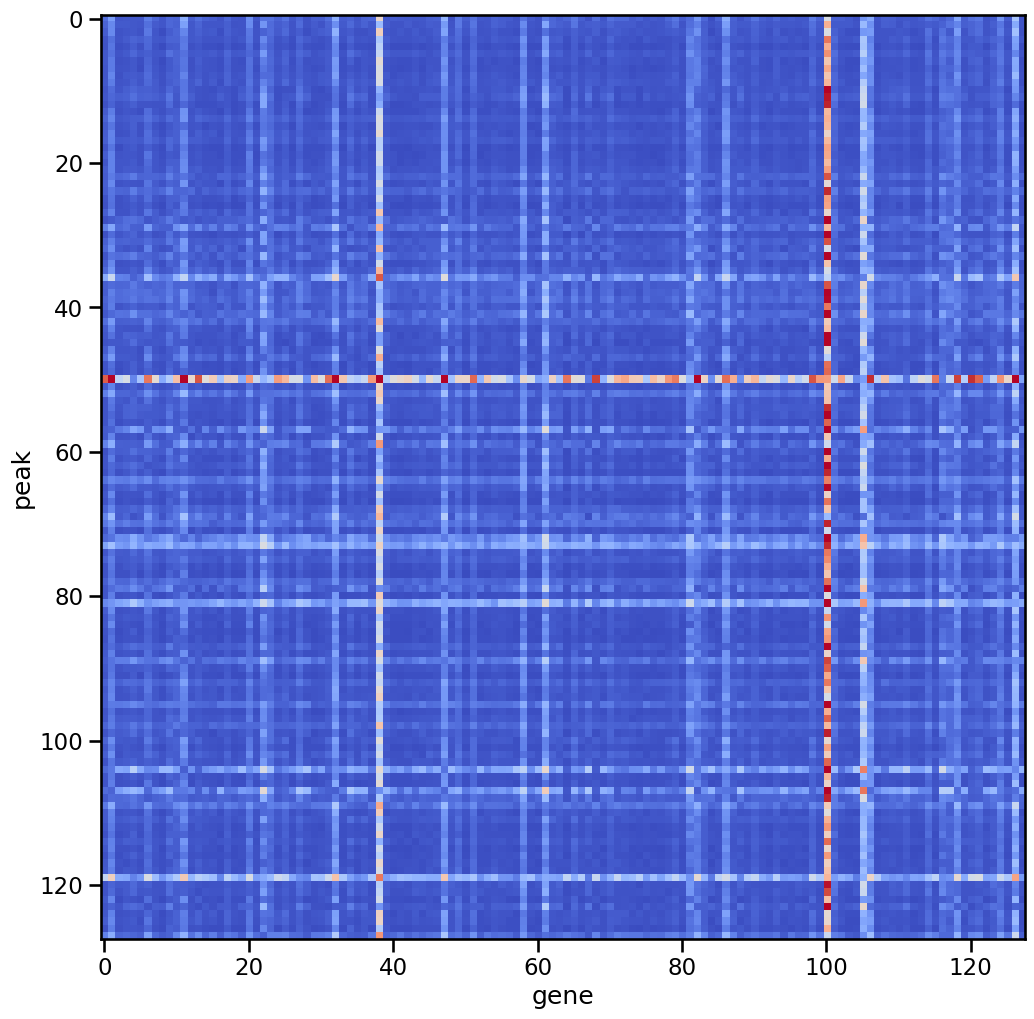

In [44]:
# att_layer = torch.concatenate((att_layer2[13],att_layer2[14],att_layer2[15],att_layer2[16]))
# att_layer_atac = torch.concatenate((att_layer2_atac[13],att_layer2_atac[14],att_layer2_atac[15],att_layer2_atac[16]))
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(12,12))
plt.imshow(att_layer2[14].mean(0).cpu().detach().numpy()+att_layer2_atac[14].mean(0).cpu().detach().numpy().T,vmax=0.2,cmap='coolwarm')
# plt.imshow(att_layer.mean(0).cpu().detach().numpy()+att_layer_atac.mean(0).cpu().detach().numpy().T,vmax=0.2)
plt.ylabel('peak')
plt.xlabel('gene')
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/attention/heatmap_rna_atac_CD4+a.pdf')

In [25]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
cross_map = att_layer2[14].mean(0).cpu().detach().numpy()+att_layer2_atac[14].mean(0).cpu().detach().numpy().T
# cross_map = att_layer.mean(0).cpu().detach().numpy()+att_layer_atac.mean(0).cpu().detach().numpy().T
# max_att = cross_map.max()
# np.where(cross_map==max_att)
# 使用 np.argsort 获取索引并取出最大五个元素
flattened_indices = np.argsort(cross_map, axis=None)[-10:]
positions = np.unravel_index(flattened_indices, cross_map.shape)
max_values = cross_map[positions]
print("最大五个元素的位置:", positions)
print("最大五个元素的值:", max_values)

最大五个元素的位置: (array([104,  50,  81,  50,  79,  45,  28,  50,  57, 107]), array([100,  47, 100,  38, 100, 100, 100, 126, 100, 100]))
最大五个元素的值: [0.22856134 0.22895715 0.23560289 0.23811974 0.23817492 0.24596313
 0.249456   0.25111216 0.25408012 0.29621255]


In [19]:
np.unique(positions[0]).shape,np.unique(positions[1]).shape

((8,), (4,))

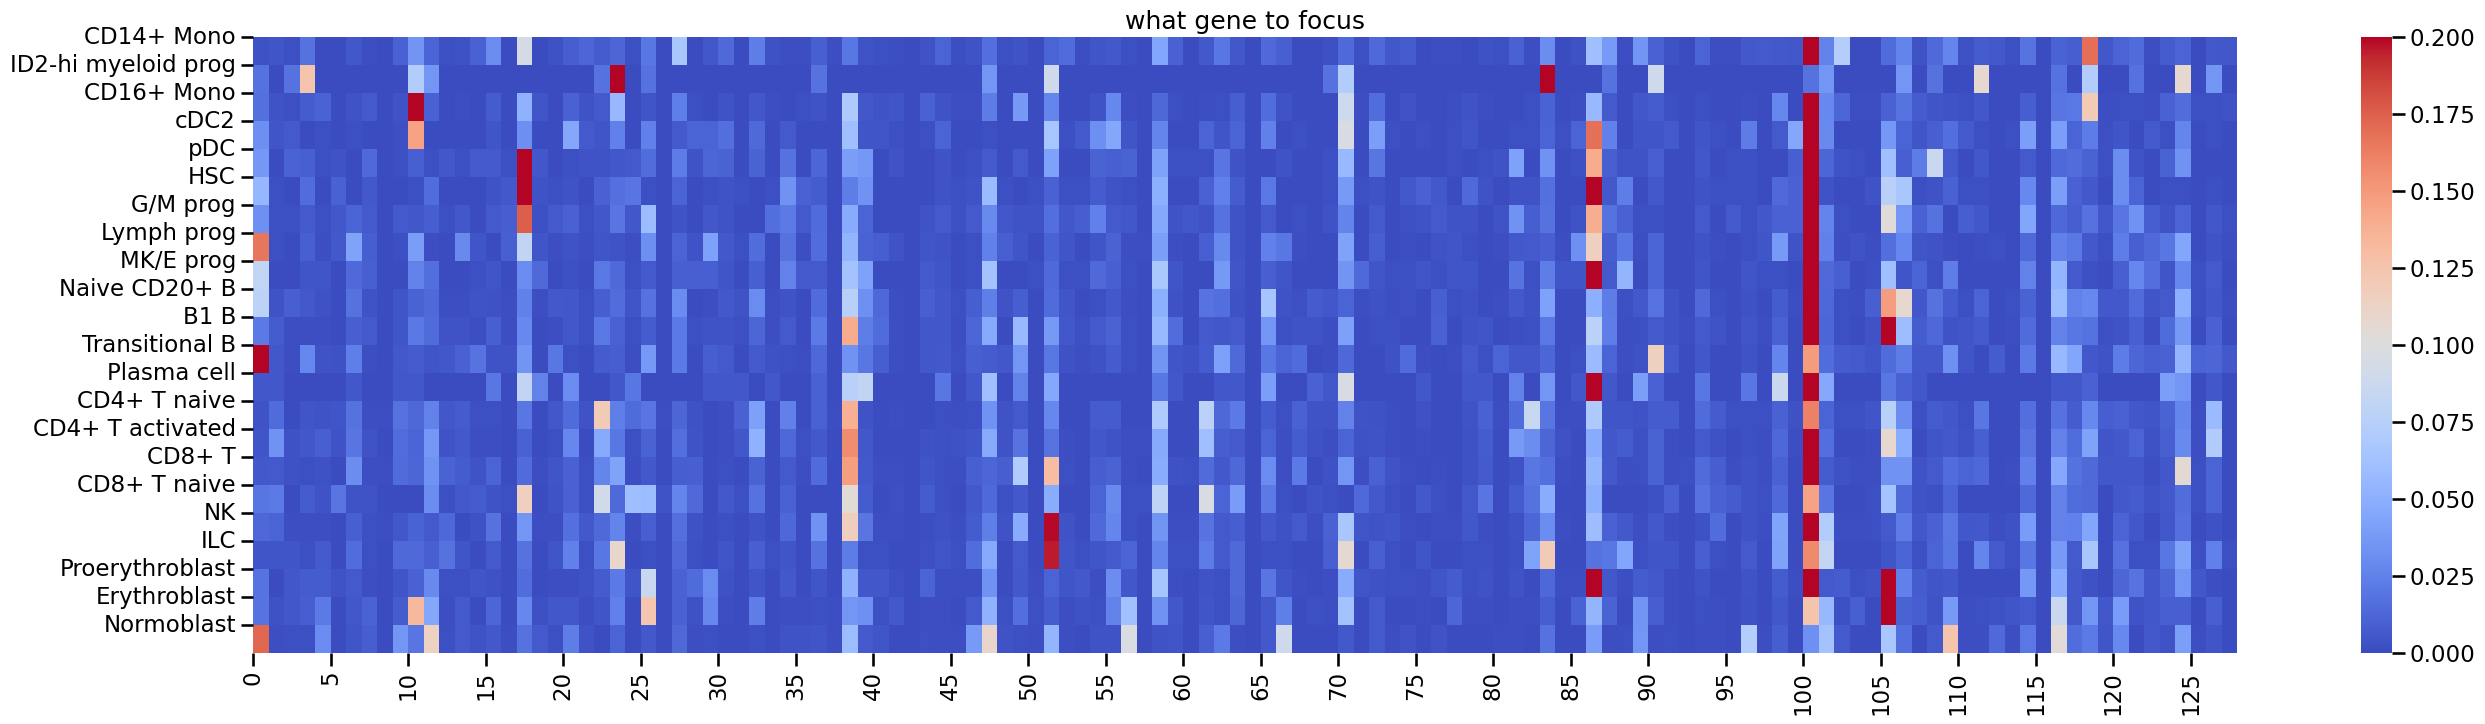

In [43]:
# peak 看了哪些 gene
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
key_col = np.zeros((len(att_layer2),att_layer2[0].shape[-1]))
for i in range(len(att_layer2)):
    for j in range(att_layer2[i].shape[0]):
        att_mean = att_layer2[i][j].mean(0).detach().cpu()
        key_c = np.where(att_mean>0.35)[0]
        for c in key_c:
            key_col[i,c] += 1
    key_col[i] = key_col[i]/att_layer2[i].shape[0]

plt.figure(figsize=(32,8))
sns.heatmap(key_col, cmap='coolwarm', vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,key_col.shape[1],5), labels=np.arange(0,key_col.shape[1],5))
plt.title('what gene to focus')
# plt.imshow(key_col,vmax=0.2)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/attention/heatmap_atac_see_rna_unsort.pdf')
# plt.colorbar()

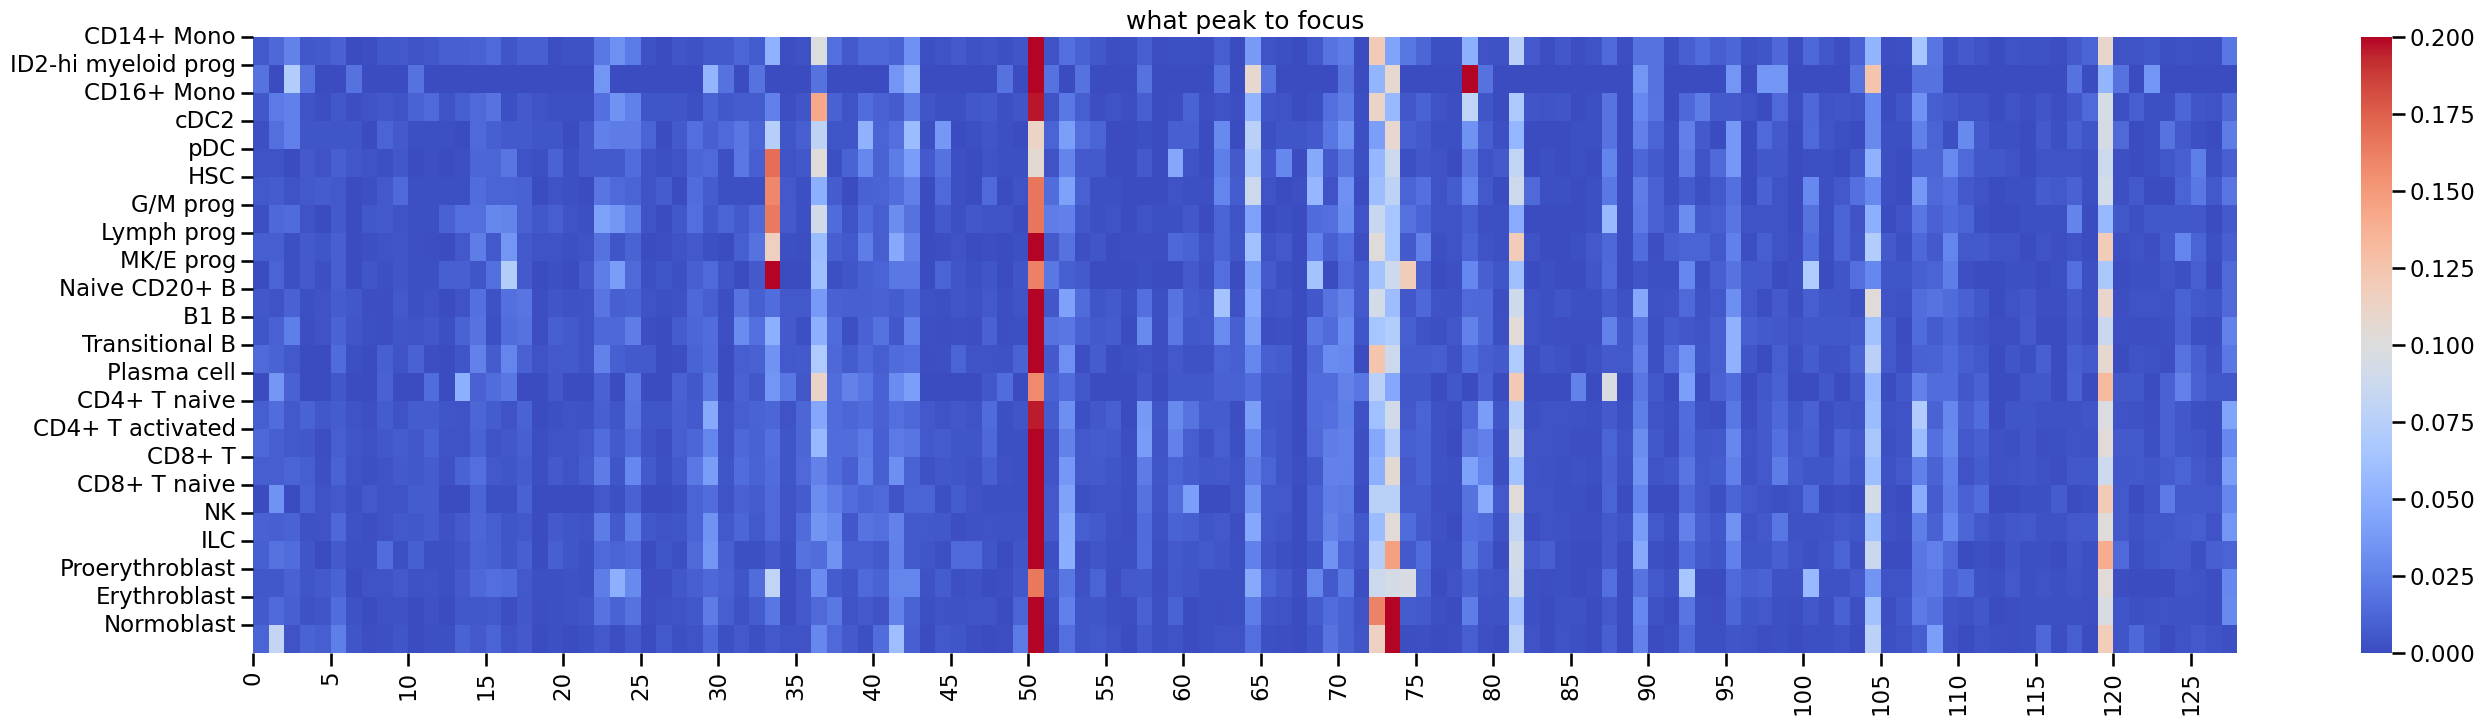

In [45]:
# gene 看了哪些 peak
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
key_col = np.zeros((len(att_layer2_atac),att_layer2_atac[0].shape[-1]))
for i in range(len(att_layer2_atac)):
    for j in range(att_layer2_atac[i].shape[0]):
        att_mean = att_layer2_atac[i][j].mean(0).detach().cpu()
        key_c = np.where(att_mean>0.35)[0]
        for c in key_c:
            key_col[i,c] += 1
    key_col[i] = key_col[i]/att_layer2_atac[i].shape[0]

plt.figure(figsize=(32,8))
sns.heatmap(key_col, cmap='coolwarm', vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,key_col.shape[1],5), labels=np.arange(0,key_col.shape[1],5))
plt.title('what peak to focus')
# plt.imshow(key_col,vmax=0.2)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/attention/heatmap_rna_see_atac_unsort.pdf')
# plt.colorbar()

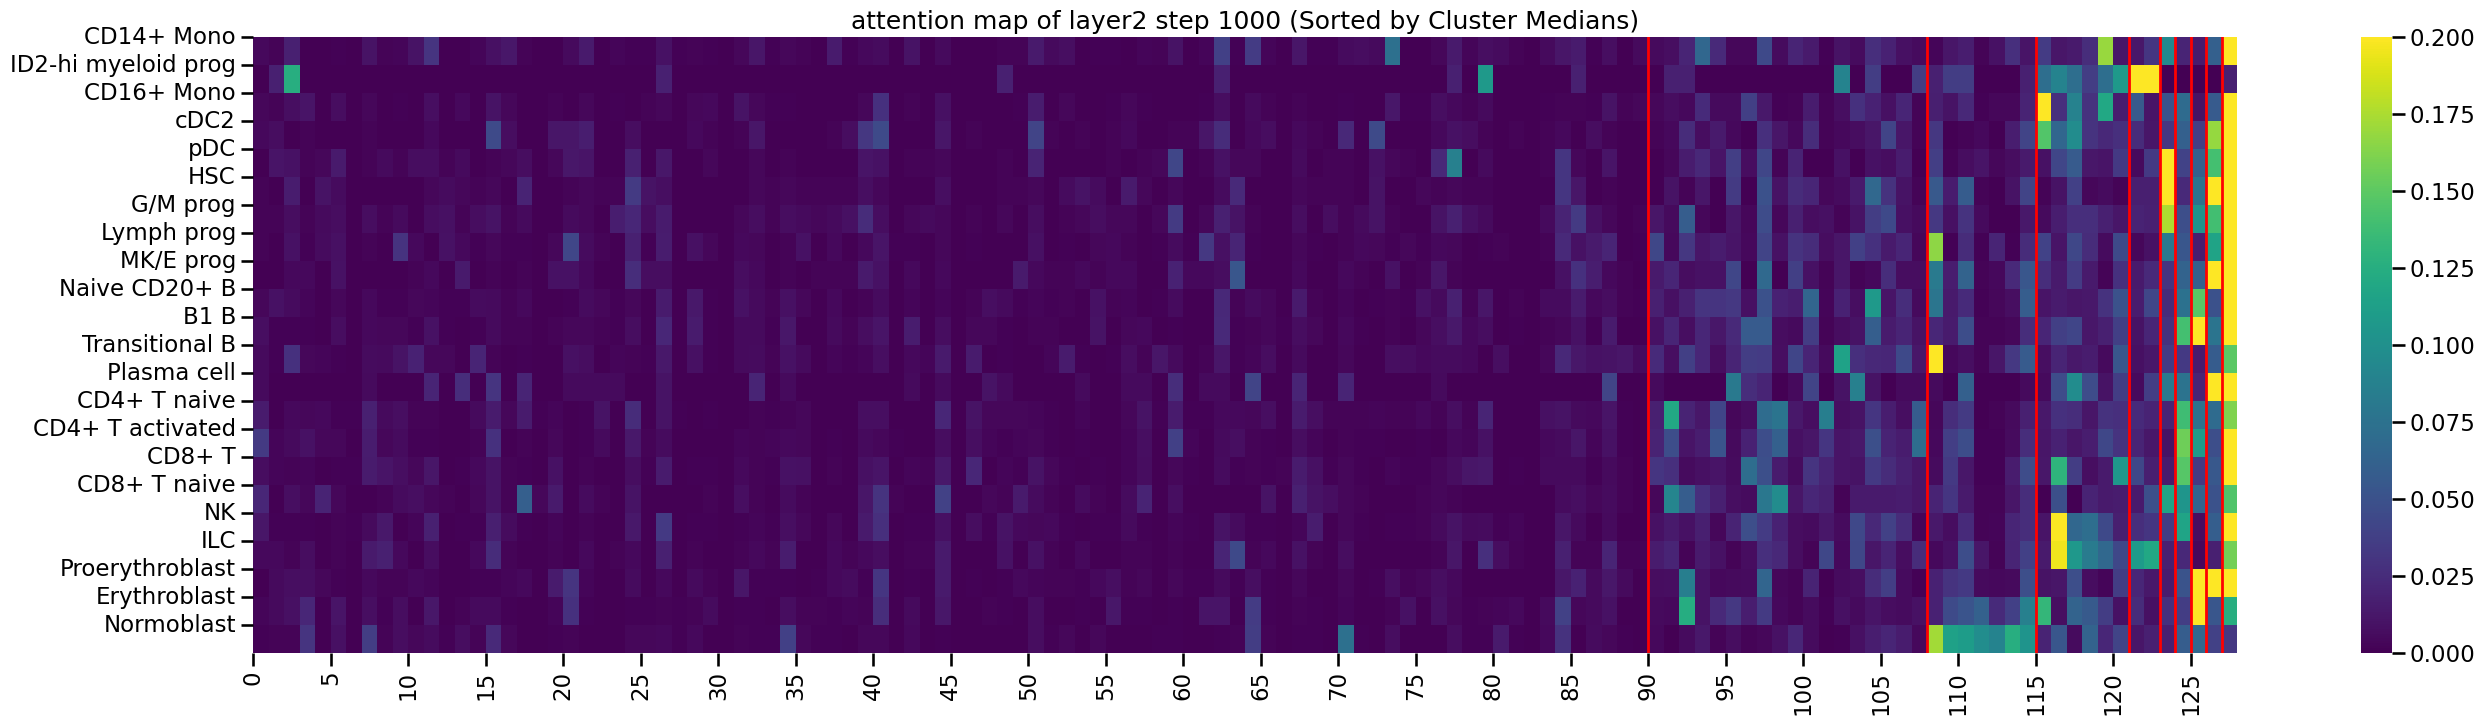

In [100]:
# peak 看了哪些 gene, 分类一下
data = key_col
matrix = pd.DataFrame(data, index=[f'Cell {i + 1}' for i in range(key_col.shape[0])],
                      columns=[f'Gene {i + 1}' for i in range(key_col.shape[1])])

# 3. 对基因进行 KMeans 聚类（列）
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters = kmeans.fit_predict(matrix.T)  # 进行基因的聚类

# 4. 计算每个聚类的中值
# 创建一个 DataFrame 以存储每个聚类的中值
cluster_means = matrix.T.groupby(clusters).mean()

# 根据中值排序
sorted_clusters = cluster_means.mean(axis=1).sort_values().index
sorted_genes = []

# 重新排列基因在 sorted_genes 中
for cluster in sorted_clusters:
    genes_in_cluster = matrix.columns[clusters == cluster]  # 找到属于该聚类的所有基因
    sorted_genes.extend(genes_in_cluster)  # 添加到排序基因列表

sorted_matrix = matrix[sorted_genes]

# 5. 生成热图
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(32, 8))
sns.heatmap(sorted_matrix, cmap='viridis', vmax=0.2)
plt.title('attention map of layer2 step 1000 (Sorted by Cluster Medians)')
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0, key_col.shape[1], 5), labels=np.arange(0, key_col.shape[1], 5))

for i in range(1, len(sorted_genes)):
    if clusters[np.where(matrix.columns == sorted_genes[i])[0][0]] != clusters[np.where(matrix.columns == sorted_genes[i - 1])[0][0]]:
        plt.axvline(x=i, color='red', linewidth=2)  # 在聚类边界绘制红色垂直线

# plt.show()
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/attention/heatmap_atac_see_rna_sort.pdf')

([<matplotlib.axis.XTick at 0x7c15b2b8a070>,
 [Text(0, 0, '129'),
  Text(5, 0, '134'),
  Text(10, 0, '139'),
  Text(15, 0, '144'),
  Text(20, 0, '149'),
  Text(25, 0, '154'),
  Text(30, 0, '159'),
  Text(35, 0, '164'),
  Text(40, 0, '169'),
  Text(45, 0, '174'),
  Text(50, 0, '179'),
  Text(55, 0, '184'),
  Text(60, 0, '189'),
  Text(65, 0, '194'),
  Text(70, 0, '199'),
  Text(75, 0, '204'),
  Text(80, 0, '209'),
  Text(85, 0, '214'),
  Text(90, 0, '219'),
  Text(95, 0, '224'),
  Text(100, 0, '229'),
  Text(105, 0, '234'),
  Text(110, 0, '239'),
  Text(115, 0, '244'),
  Text(120, 0, '249'),
  Text(125, 0, '254')])

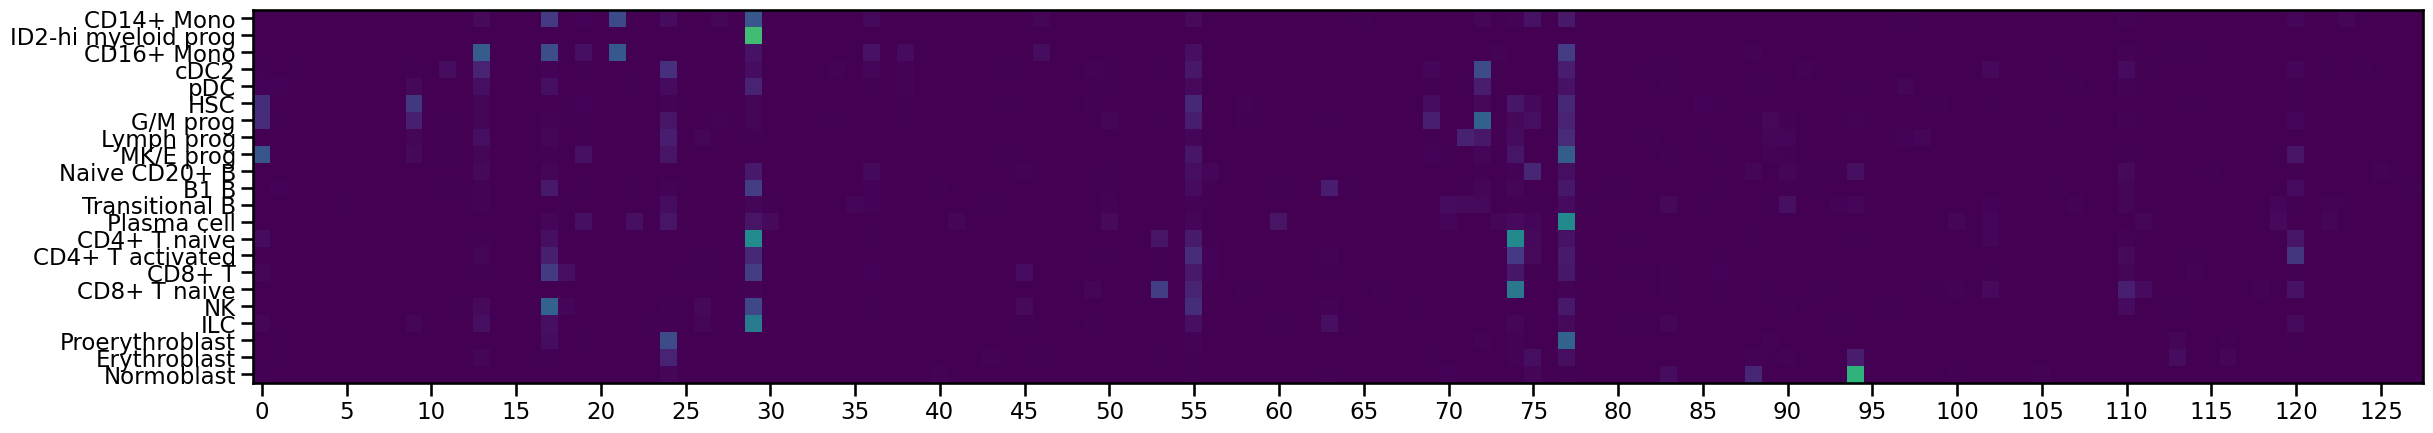

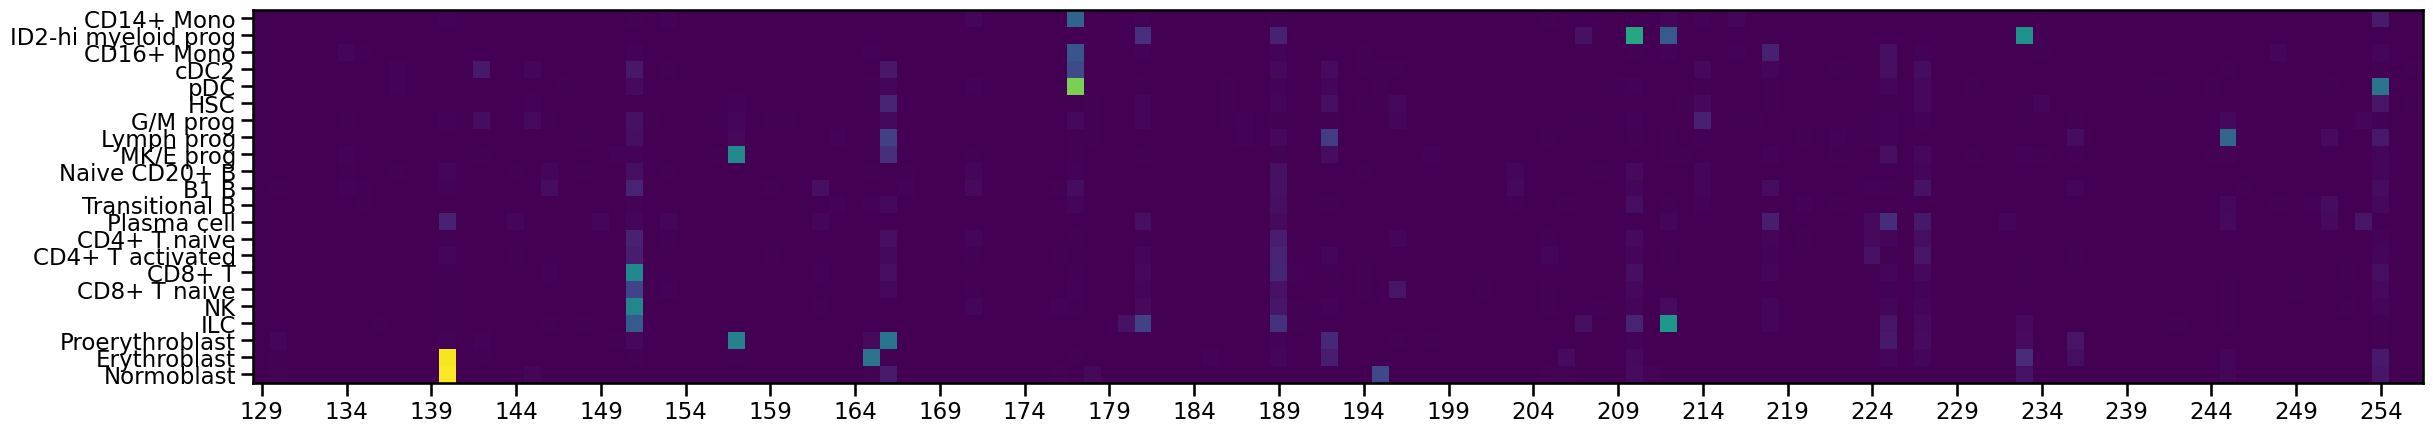

In [70]:
key_col = np.zeros((len(att_layer1),att_layer1[0].shape[-1]))
for i in range(len(att_layer1)):
    for j in range(att_layer1[i].shape[0]):
        att_mean = att_layer1[i][j].mean(0).detach().cpu()
        key_c = np.where(att_mean>0.35)[0]
        for c in key_c:
            key_col[i,c] += 1
    key_col[i] = key_col[i]/att_layer1[i].shape[0]

plt.figure(figsize=(28,12))
plt.imshow(key_col[:,:128],vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,128,5), labels=np.arange(0,128,5))

plt.figure(figsize=(28,12))
plt.imshow(key_col[:,128:],vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,128,5), labels=np.arange(129,256,5))
# plt.colorbar()

([<matplotlib.axis.XTick at 0x7c15b2a81310>,
 [Text(0, 0, '129'),
  Text(5, 0, '134'),
  Text(10, 0, '139'),
  Text(15, 0, '144'),
  Text(20, 0, '149'),
  Text(25, 0, '154'),
  Text(30, 0, '159'),
  Text(35, 0, '164'),
  Text(40, 0, '169'),
  Text(45, 0, '174'),
  Text(50, 0, '179'),
  Text(55, 0, '184'),
  Text(60, 0, '189'),
  Text(65, 0, '194'),
  Text(70, 0, '199'),
  Text(75, 0, '204'),
  Text(80, 0, '209'),
  Text(85, 0, '214'),
  Text(90, 0, '219'),
  Text(95, 0, '224'),
  Text(100, 0, '229'),
  Text(105, 0, '234'),
  Text(110, 0, '239'),
  Text(115, 0, '244'),
  Text(120, 0, '249'),
  Text(125, 0, '254')])

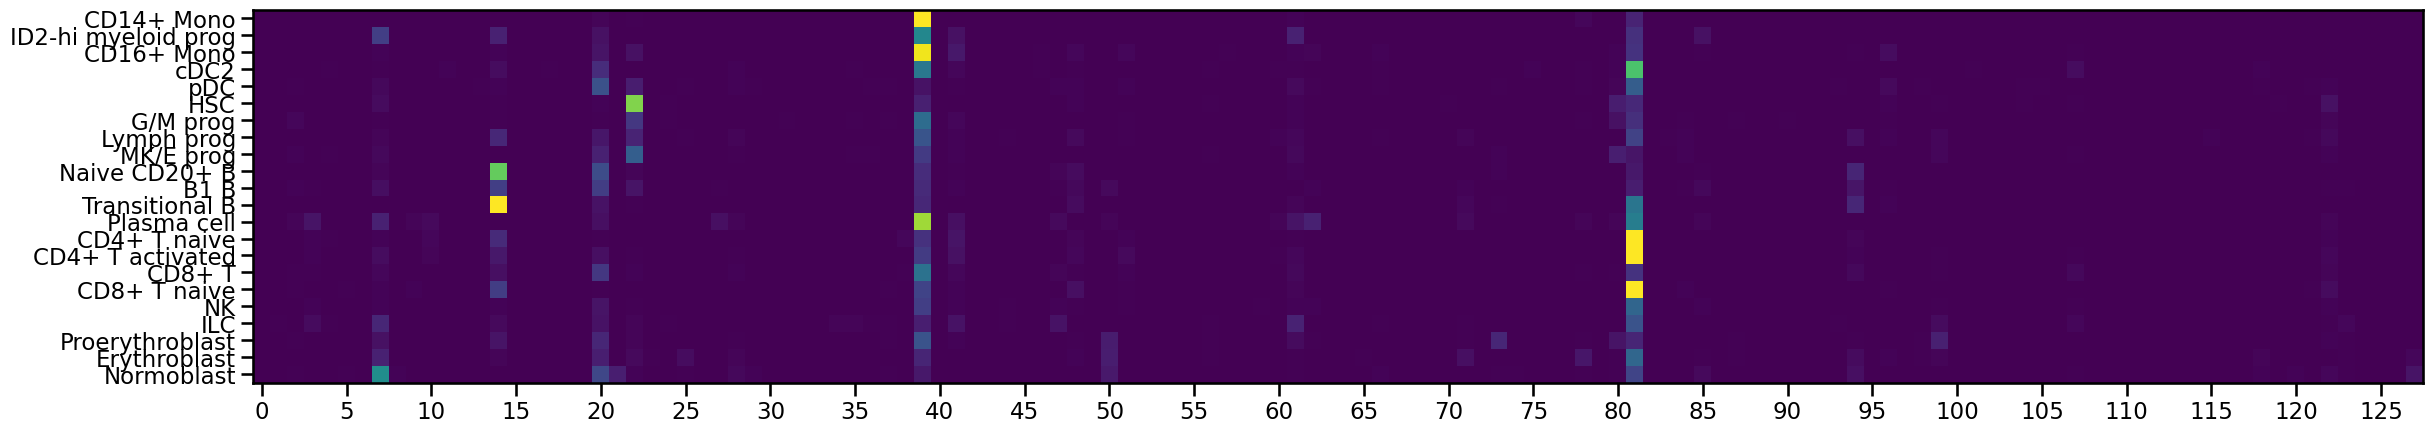

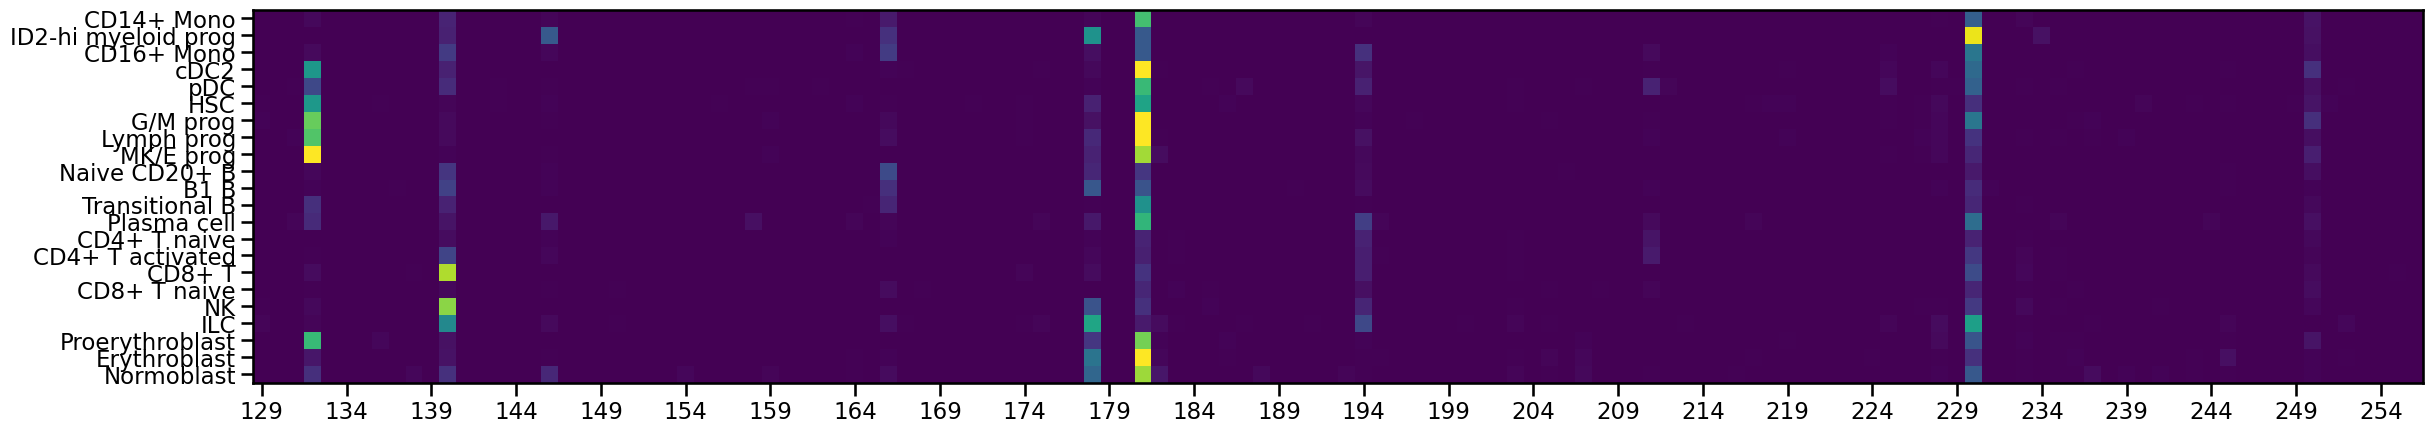

In [71]:
key_col = np.zeros((len(att_layer3),att_layer3[0].shape[-1]))
for i in range(len(att_layer3)):
    for j in range(att_layer3[i].shape[0]):
        att_mean = att_layer3[i][j].mean(0).detach().cpu()
        key_c = np.where(att_mean>0.35)[0]
        for c in key_c:
            key_col[i,c] += 1
    key_col[i] = key_col[i]/att_layer3[i].shape[0]

plt.figure(figsize=(28,12))
plt.imshow(key_col[:,:128],vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,128,5), labels=np.arange(0,128,5))

plt.figure(figsize=(28,12))
plt.imshow(key_col[:,128:],vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,128,5), labels=np.arange(129,256,5))

([<matplotlib.axis.XTick at 0x7feaae9b5df0>,
 [Text(0, 0, '129'),
  Text(5, 0, '134'),
  Text(10, 0, '139'),
  Text(15, 0, '144'),
  Text(20, 0, '149'),
  Text(25, 0, '154'),
  Text(30, 0, '159'),
  Text(35, 0, '164'),
  Text(40, 0, '169'),
  Text(45, 0, '174'),
  Text(50, 0, '179'),
  Text(55, 0, '184'),
  Text(60, 0, '189'),
  Text(65, 0, '194'),
  Text(70, 0, '199'),
  Text(75, 0, '204'),
  Text(80, 0, '209'),
  Text(85, 0, '214'),
  Text(90, 0, '219'),
  Text(95, 0, '224'),
  Text(100, 0, '229'),
  Text(105, 0, '234'),
  Text(110, 0, '239'),
  Text(115, 0, '244'),
  Text(120, 0, '249'),
  Text(125, 0, '254')])

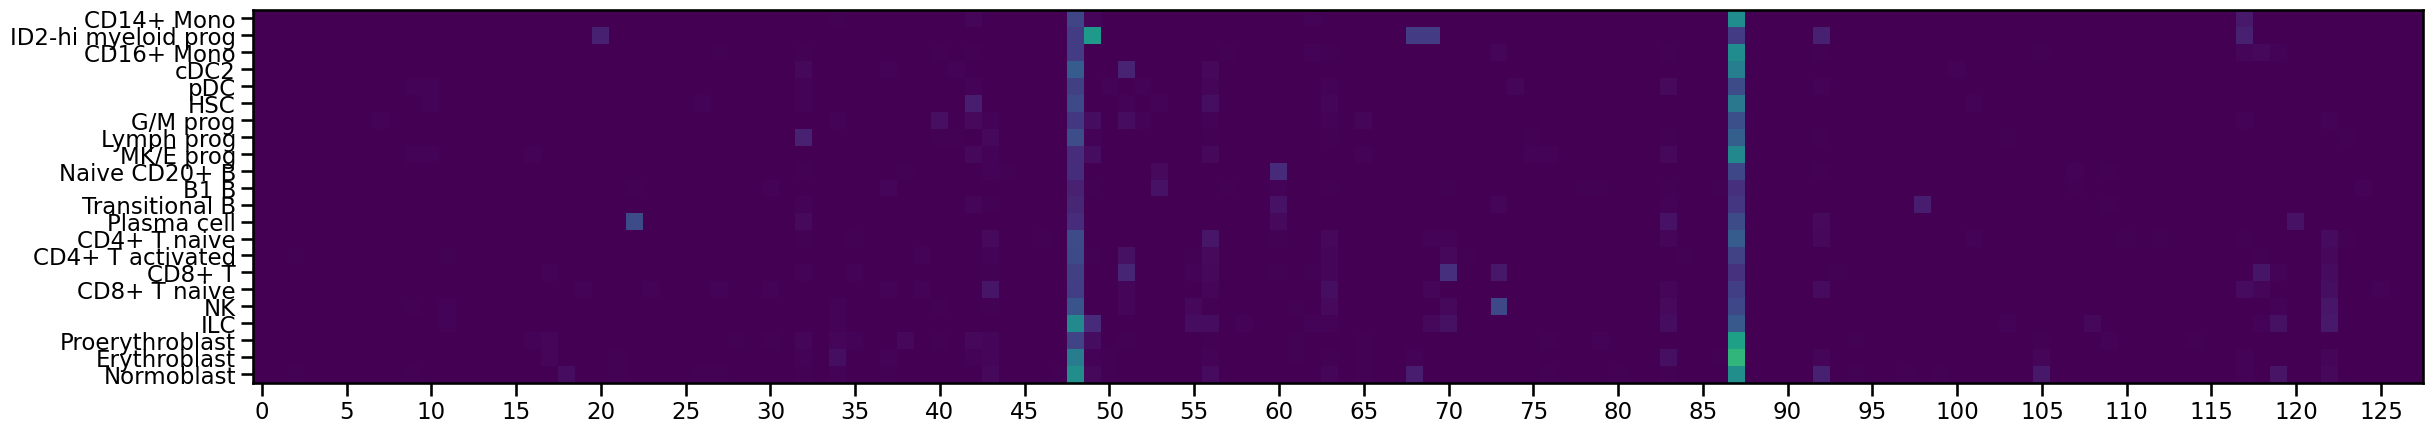

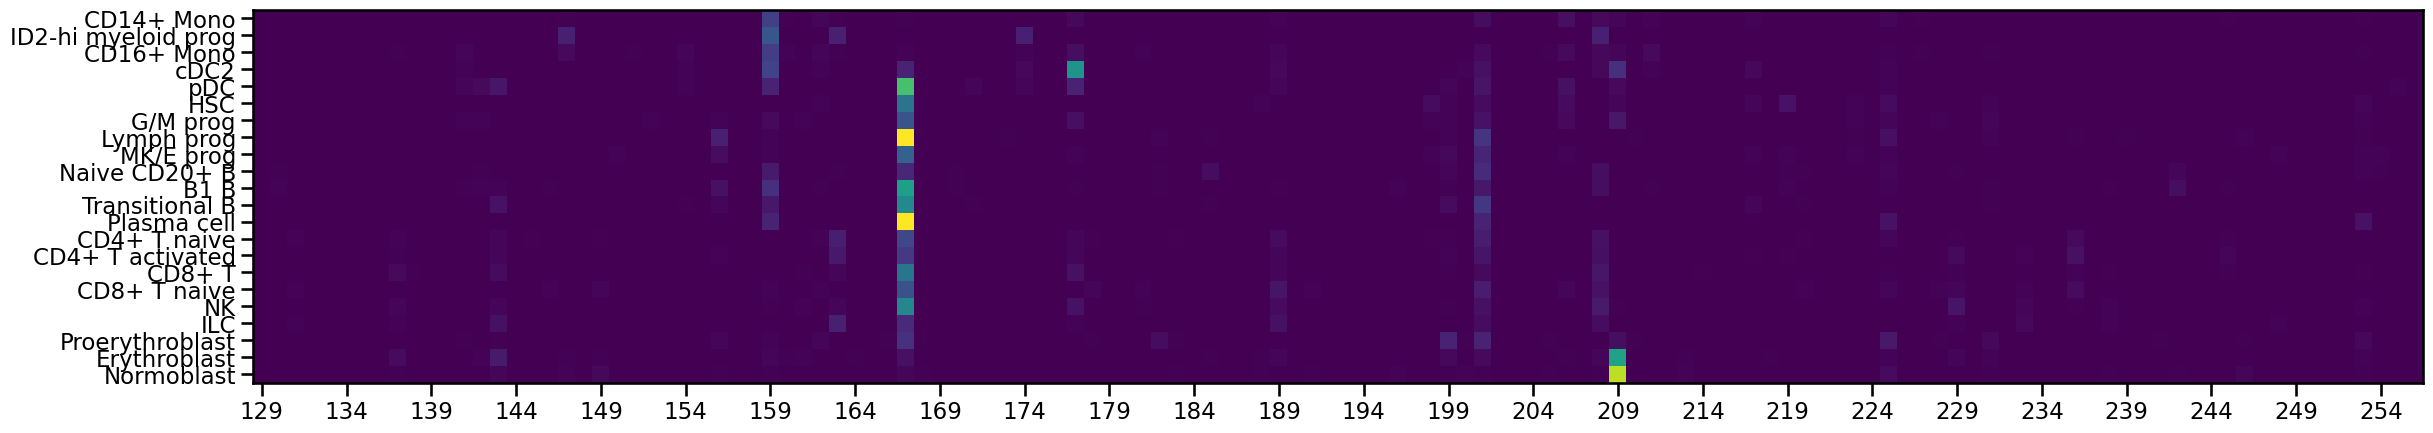

In [17]:
key_col = np.zeros((len(att_layer1_atac),att_layer1_atac[0].shape[-1]))
for i in range(len(att_layer1_atac)):
    for j in range(att_layer1_atac[i].shape[0]):
        att_mean = att_layer1_atac[i][j].mean(0).detach().cpu()
        key_c = np.where(att_mean>0.35)[0]
        for c in key_c:
            key_col[i,c] += 1
    key_col[i] = key_col[i]/att_layer1_atac[i].shape[0]

plt.figure(figsize=(28,12))
plt.imshow(key_col[:,:128],vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,128,5), labels=np.arange(0,128,5))

plt.figure(figsize=(28,12))
plt.imshow(key_col[:,128:],vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,128,5), labels=np.arange(129,256,5))
# plt.colorbar()

([<matplotlib.axis.XTick at 0x7feaae7cb070>,
 [Text(0, 0, '129'),
  Text(5, 0, '134'),
  Text(10, 0, '139'),
  Text(15, 0, '144'),
  Text(20, 0, '149'),
  Text(25, 0, '154'),
  Text(30, 0, '159'),
  Text(35, 0, '164'),
  Text(40, 0, '169'),
  Text(45, 0, '174'),
  Text(50, 0, '179'),
  Text(55, 0, '184'),
  Text(60, 0, '189'),
  Text(65, 0, '194'),
  Text(70, 0, '199'),
  Text(75, 0, '204'),
  Text(80, 0, '209'),
  Text(85, 0, '214'),
  Text(90, 0, '219'),
  Text(95, 0, '224'),
  Text(100, 0, '229'),
  Text(105, 0, '234'),
  Text(110, 0, '239'),
  Text(115, 0, '244'),
  Text(120, 0, '249'),
  Text(125, 0, '254')])

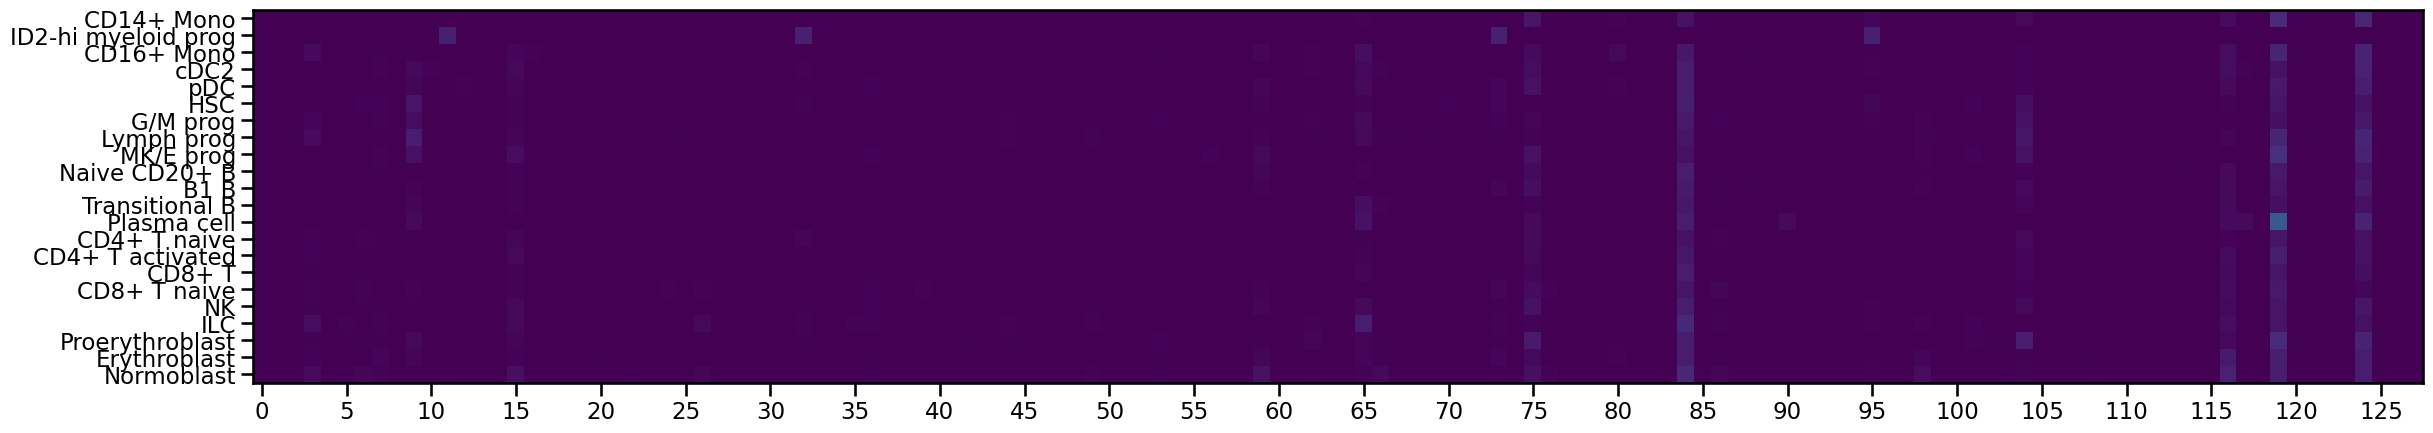

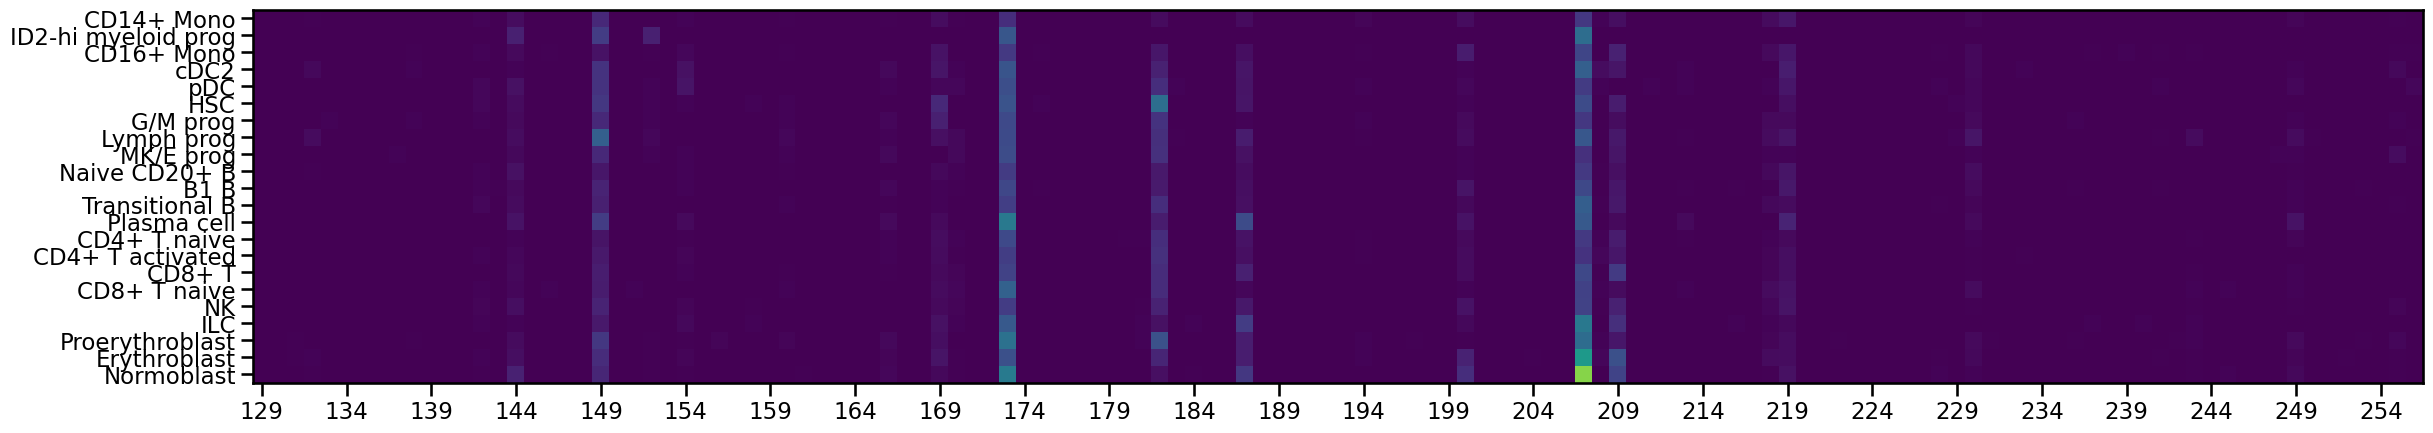

In [18]:
key_col = np.zeros((len(att_layer3_atac),att_layer3_atac[0].shape[-1]))
for i in range(len(att_layer3_atac)):
    for j in range(att_layer3_atac[i].shape[0]):
        att_mean = att_layer3_atac[i][j].mean(0).detach().cpu()
        key_c = np.where(att_mean>0.35)[0]
        for c in key_c:
            key_col[i,c] += 1
    key_col[i] = key_col[i]/att_layer3_atac[i].shape[0]

plt.figure(figsize=(28,12))
plt.imshow(key_col[:,:128],vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,128,5), labels=np.arange(0,128,5))

plt.figure(figsize=(28,12))
plt.imshow(key_col[:,128:],vmax=0.2)
plt.yticks(ticks=np.arange(type_list.shape[0]), labels=type_list)
plt.xticks(ticks=np.arange(0,128,5), labels=np.arange(129,256,5))
# plt.colorbar()

找key elements

In [34]:
common_ele_all = {}
for i in range(len(key_col)):
    # top_indices = np.argsort(key_col[i])[-8:][::-1]
    top_indices = np.where(key_col[i]>0.06)[0]
    common_ele_all[type_list[i]] = top_indices
common_ele_all

{'CD14+ Mono': array([ 10,  17, 100, 102, 118]),
 'ID2-hi myeloid prog': array([ 10,  23,  58,  70,  83,  90, 124]),
 'CD16+ Mono': array([ 10,  23,  70, 100, 118]),
 'cDC2': array([ 10,  55,  70,  86, 100]),
 'pDC': array([ 17,  38,  70,  86, 100, 108]),
 'HSC': array([ 17,  34,  86, 100, 106]),
 'G/M prog': array([ 17,  38,  86, 100]),
 'Lymph prog': array([  0,  10,  38,  86, 100]),
 'MK/E prog': array([ 38,  58,  86, 100]),
 'Naive CD20+ B': array([  0,  38, 100, 106, 124]),
 'B1 B': array([ 10,  38, 100, 105, 106]),
 'Transitional B': array([  0,  86,  90, 100, 124]),
 'Plasma cell': array([ 17,  38,  39,  47,  70,  86, 100]),
 'CD4+ T naive': array([ 22,  38,  58,  61,  82, 100, 126]),
 'CD4+ T activated': array([ 38, 100, 126]),
 'CD8+ T': array([ 23,  38,  51, 100, 124]),
 'CD8+ T naive': array([ 17,  22,  34,  38,  58, 100]),
 'NK': array([ 38,  51,  70, 100]),
 'ILC': array([ 23,  51,  58,  70,  83, 100, 101]),
 'Proerythroblast': array([ 25,  38,  55,  58,  70,  86, 100, 105

# 看某个具体cell的attention map

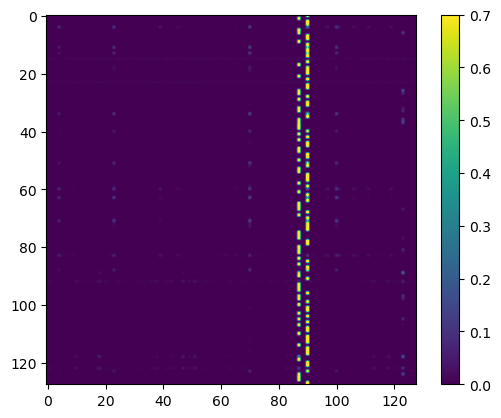

In [ ]:
# 1
plt.imshow(att_layer2[2][0].detach().cpu(), vmax=0.7)
plt.colorbar()

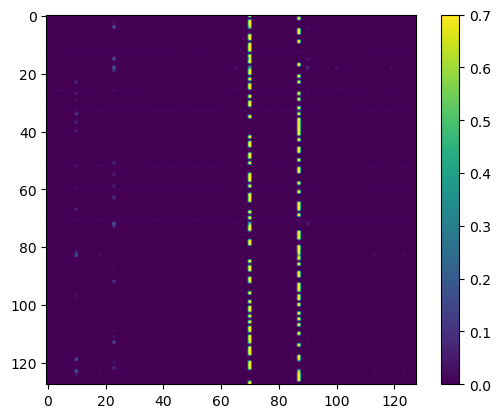

In [ ]:
# 50
plt.imshow(att_layer2[2][0].detach().cpu(), vmax=0.7)
plt.colorbar()

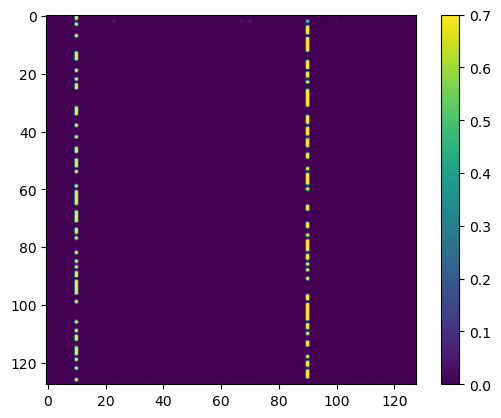

In [ ]:
# 100
plt.imshow(att_layer2[2][0].detach().cpu(), vmax=0.7)
plt.colorbar()

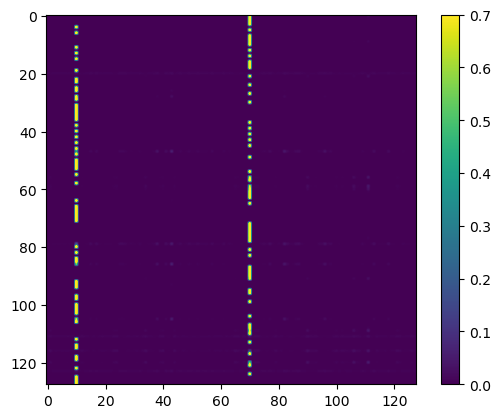

In [ ]:
# 100
plt.imshow(att_layer2[2][1].detach().cpu(), vmax=0.7)
plt.colorbar()

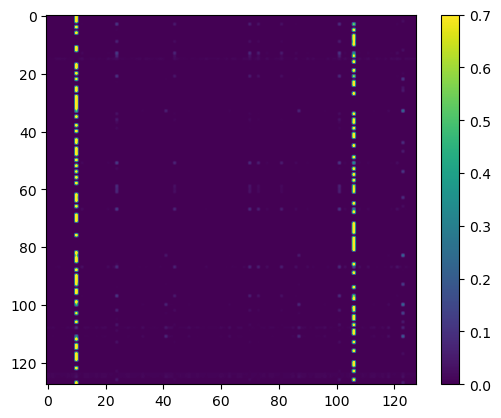

In [ ]:
# 100
plt.imshow(att_layer2[2][3].detach().cpu(), vmax=0.7)
plt.colorbar()

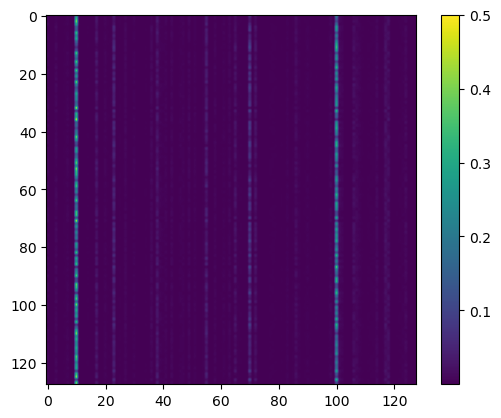

In [ ]:
# 100
plt.imshow(att_layer2[2].mean(0).detach().cpu(), vmax=0.5)
plt.colorbar()

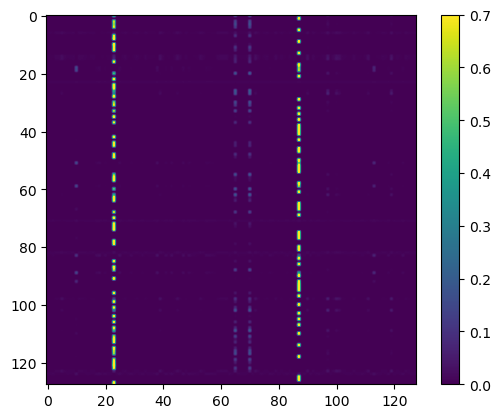

In [ ]:
# 150
plt.imshow(att_layer2[2][0].detach().cpu(), vmax=0.7)
plt.colorbar()

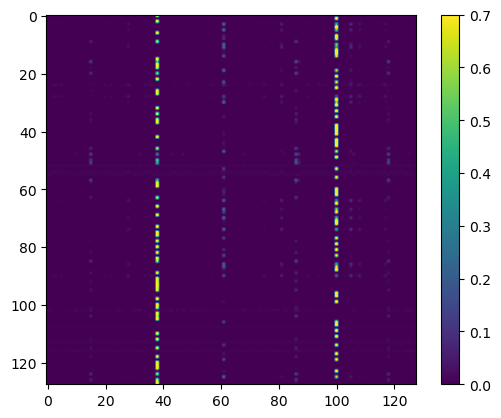

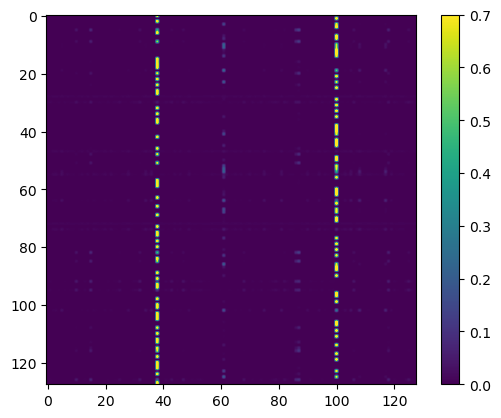

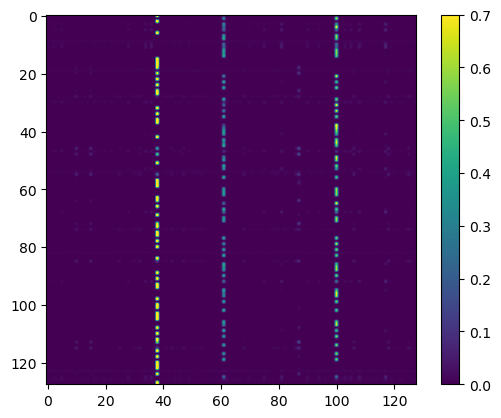

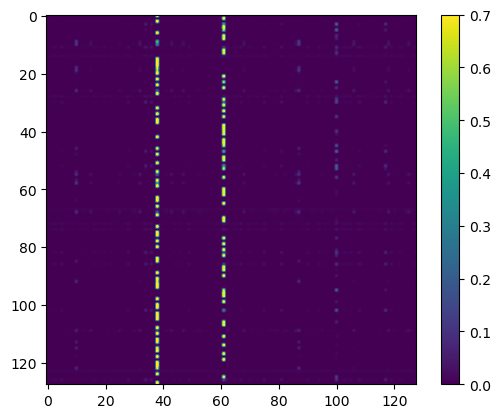

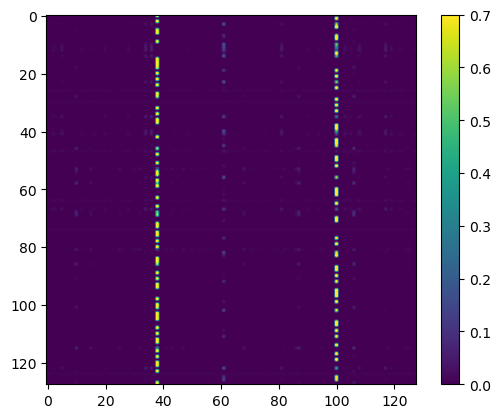

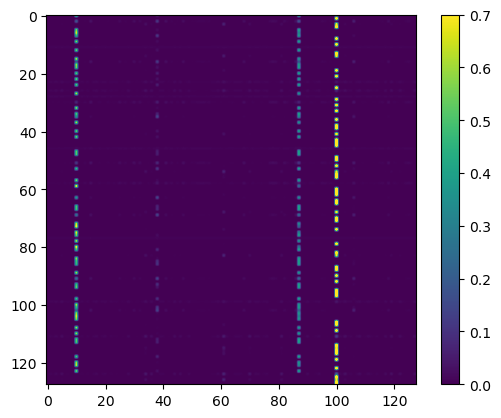

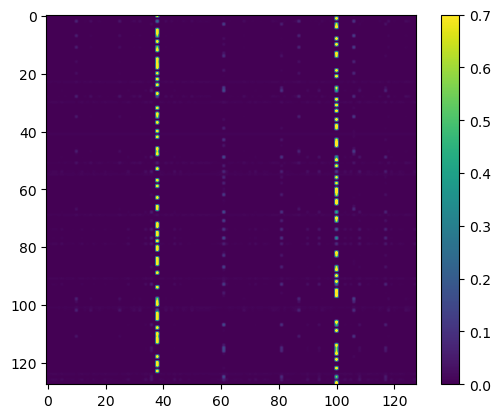

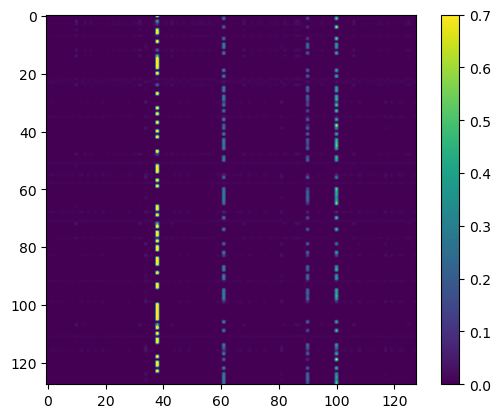

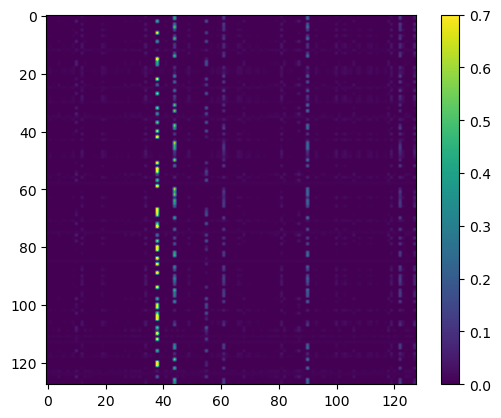

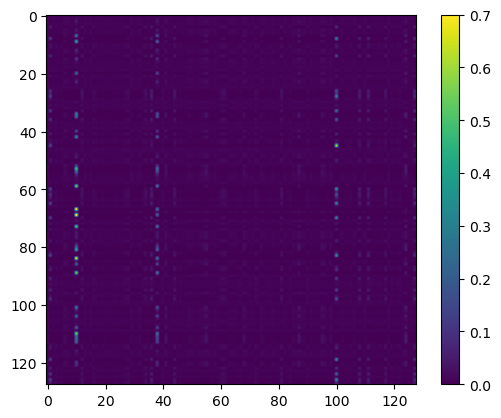

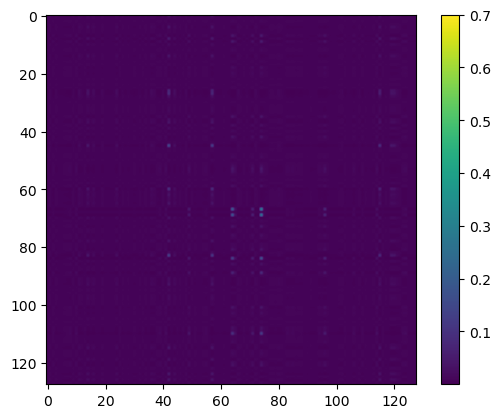

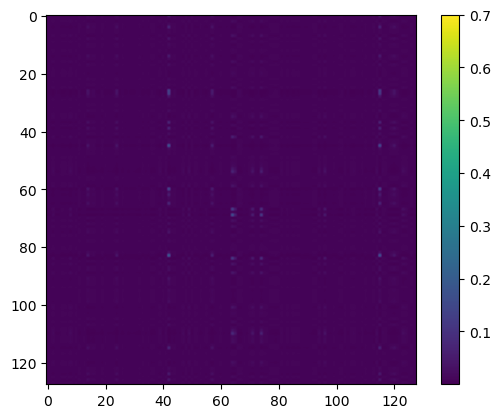

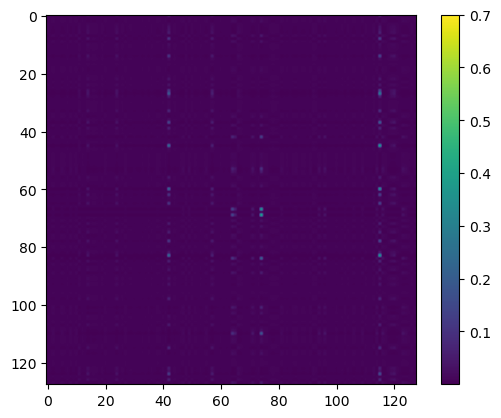

In [ ]:
x1 = torch.tensor(rna[::down_sample].X.toarray(),requires_grad=True)
x2 = torch.tensor(atac[::down_sample].X.toarray(),requires_grad=True)
for t in [1,25,50,75,100,125,150,200,300,400,500,700,900]:
    time_step = t
    down_sample = 10
    model_kwargs = {}
    batch = {}

    batch["X_norm"] = {'rna':x1,'atac':x2}
    z = encoder_model.encode(batch)
    video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
    audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
    model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())

    noise ={"video":torch.randn_like(video_start),\
        "audio":torch.randn_like(audio_start)}

    #0 means t_th step, 1 means the audio gives groundtruth, 2 means the video gives the groundtruth
    # condition_index = x_start["condition"]  
    t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
    video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])#.detach()
    audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])#.detach()

    att_layer1 = []
    att_layer2 = []
    att_layer3 = []

    index = (rna[::down_sample].obs['cell_type'] == type_list[3])
    # sample_id = np.random.choice(np.arange(0, index.sum()), size=22, replace=False)
    video_t_i = video_t[index]#[sample_id]
    audio_t_i = audio_t[index]#[sample_id]
    t_i = t[index]#[sample_id]
    labels = model_kwargs["label"][index]#[sample_id]

    noise_pred_video, noise_pred_video, att_maps = multimodal_model(video_t_i,audio_t_i,t_i,labels,return_attvec=True)
    plt.figure()
    plt.imshow(att_maps[3][0].detach().cpu(), vmax=0.7)
    plt.colorbar()

# gradient back propagation analysis

analysis denoising network gradient

In [ ]:
# (array(['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
#         'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
#         'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
#         'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
#         'Proerythroblast', 'Transitional B', 'cDC2', 'pDC'], dtype=object),
#  array([ 1890, 10843,  1894,  5526,  4398, 11589,  1012,  4916,  1203,
#          1072,   108,   835,  1779,   884,  6929,  5052,  1780,   379,
#          2300,  2810,   859,  1191]))

In [20]:
time_step = 1
interested_type = type_list[14] #'CD4+ T naive' #'CD4+ T activated' #'HSC' #'all' #'pDC' #'Normoblast' # 'ID2-hi myeloid prog' # 'Proerythroblast' #'B1 B' #'cDC2' #'MK/E prog'
down_sample = 5
model_kwargs = {}
batch = {}

x1 = torch.tensor(rna[::down_sample].X.toarray(),requires_grad=True)
x2 = torch.tensor(atac[::down_sample].X.toarray(),requires_grad=True)
index = list(range(rna[::down_sample].shape[0])) if interested_type=='all' else (rna[::down_sample].obs['cell_type'] == interested_type)
# index = np.where(np.isin(rna[::down_sample].obs['cell_type'].values,['CD4+ T activated','CD4+ T naive', 'CD8+ T', 'CD8+ T naive']))[0] 

batch["X_norm"] = {'rna':x1,'atac':x2}
z = encoder_model.encode(batch)
video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())

noise ={"video":torch.randn_like(video_start),\
    "audio":torch.randn_like(audio_start)}

#0 means t_th step, 1 means the audio gives groundtruth, 2 means the video gives the groundtruth
# condition_index = x_start["condition"]  
t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])#.detach()
audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])#.detach()


video_t = video_t[index]
audio_t = audio_t[index]
t = t[index]
labels = model_kwargs["label"][index]

# video_t.requires_grad = True
# audio_t.requires_grad = True

看某个具体细胞

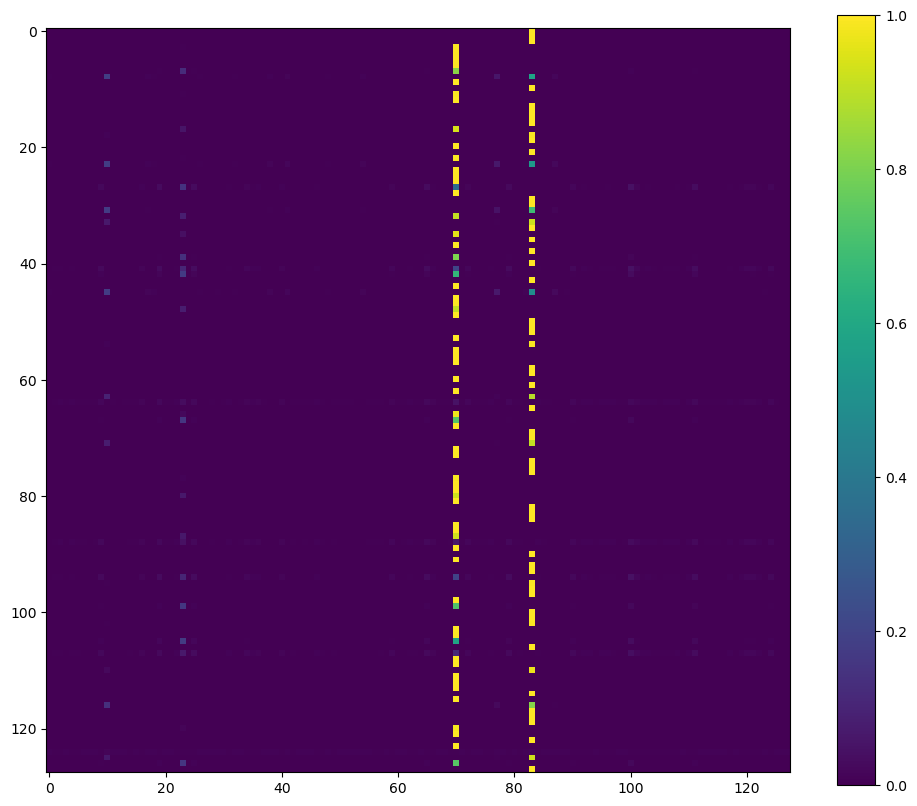

In [52]:
cell_id = 6
noise_pred_video, noise_pred_video, att_vec = multimodal_model(video_t[cell_id].unsqueeze(0),audio_t[cell_id].unsqueeze(0),t[cell_id].unsqueeze(0),labels[cell_id].unsqueeze(0),return_attvec=True)

plt.figure(figsize=(12,10))
plt.imshow(att_vec[7].squeeze(0).detach().cpu().numpy())
plt.colorbar()

In [53]:
att_vec[4][:,84].sum().backward(create_graph=True)
top_k = 13431
values, indices = torch.topk(abs(x1.grad[index][cell_id])*(x1[index][cell_id]>0), top_k)#
x1.grad.zero_()
x2.grad.zero_()
# mdata['rna'].var_names[indices]
top_gene = np.array([mdata['rna'].var_names[id] for id in np.array(indices)])
print(top_gene[:50])
rna[::down_sample][index][cell_id,top_gene[:50]].X.toarray()

['AP001042.1' 'AL132780.1' 'RBPMS' 'SDR42E2' 'OAS1' 'AL627309.5' 'ADAP2'
 'CSTF1' 'AC079305.3' 'MPV17L' 'AC008750.7' 'CCDC61' 'ZEB2-AS1' 'ANKDD1B'
 'TCIRG1' 'TMCC3' 'FIRRE' 'VDR' 'MED29' 'FYCO1' 'BATF' 'LINC00847'
 'SH3BP1' 'PITPNM1' 'ZNF7' 'DNASE1L1' 'BCAT2' 'CCDC30' 'ALOX5' 'SIRPD'
 'RPL26L1' 'ZC3H7A' 'TRIB1' 'ZFAND1' 'FBRS' 'FGD6' 'GGCT' 'MARCKS' 'CCSAP'
 'AC068724.3' 'MSR1' 'IER5L' 'CCT8' 'PET117' 'SREBF1' 'BASP1' 'FAM178B'
 'MARCH1' 'HSPH1' 'ZBTB17']


array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1.,
        1., 1., 1., 1., 1., 1., 1., 3., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
        1., 1.]], dtype=float32)

看整体

0 rna_vector, 1 atac_vector, 2 rna_see_atac, 3 atac_see_rna

In [24]:
np.unique(positions[0])

array([10905])

In [70]:
# marker = ['BDCA2','BDCA4','CD123','CD45RA','GZMB','HLA-DR','JCHAIN','LILRA4','TCL1A']
# marker = ['TCF4','IL3RA','MZB1','JCHAIN','CD4','ID2','CDK6','TYROBP','FCER1G']  # pDC
# marker = ['HBM','SLC4A1','SLC25A37']   # Normoblast
# marker = ['HBM','SLC4A1','SLC25A37','MKI67','CDK6','SYNGR1','ITGB1']   # Proerythroblast
# marker = ['VCAN','ID2','KLF4','HBM'] # ID2-hi myeloid prog
# marker = ['TCF4','MS4A1','ITGB1','SSPN'] # 'B1 B'
marker = np.unique(['VCAN','ID2','MS4A1','ITGB1','SSPN','KLF4','HBM','TCF4','IL3RA','MZB1','JCHAIN','CD4','ID2','CDK6','TYROBP','FCER1G','HBM','SLC4A1','SLC25A37','MKI67','CDK6','SYNGR1','ITGB1'])
# marker = top_gene[:9]
# 最大五个元素的位置: (array([ 70,  50,  38,  28,  92,  45,  95,  81, 107,  50]), array([100, 100, 100, 100, 100, 100, 100, 100, 100, 126]))
# 最大五个元素的位置: (array([ 95, 127,  92,  81, 107,  28,  45,  50,  50,  50]), array([100,  38, 100, 100, 100, 100, 100,  51, 100,  38]))
# 45,  81,  95, 107,  50
all_key_genes = [] 
all_key_peaks = [] 
all_position = []
# for key_ele in np.unique(key_set[interested_type]):
for key_ele in np.unique(positions[1]):#[126,100]:#51,100,38     38,126,    51, 100,  38
# for key_ele in np.unique(common_ele_all[interested_type]):
# for key_ele in range(128):

    batch["X_norm"] = {'rna':x1,'atac':x2}
    z = encoder_model.encode(batch)
    video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
    audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
    model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())
    noise ={"video":torch.randn_like(video_start),\
        "audio":torch.randn_like(audio_start)}
    t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
    video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])
    audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])
    video_t = video_t[index]
    audio_t = audio_t[index]
    t = t[index]
    labels = model_kwargs["label"][index]

    noise_pred_video, noise_pred_audio, att_vec = multimodal_model(video_t,audio_t,t,labels,return_attvec=True)
    # att_vec[2][:,:,key_ele].mean().backward(create_graph=True)
    att_vec[4][:,:,key_ele].mean().backward(create_graph=True,)
    # att_vec[7][:,:,key_ele].sum(1).mean().backward(create_graph=True)
    top_k = 13431
    values, indices = torch.topk(abs(x1.grad[index]).mean(0)*(x1[index].sum(0)>int(x1[index].shape[0]*0.2)), top_k)#

    # mdata['rna'].var_names[indices]
    top_gene = np.array([mdata['rna'].var_names[id] for id in np.array(indices)])
    # print('top_gene: ',top_gene[:10])
    all_key_genes += list(top_gene[:100])
    # all_key_genes.append(list(top_gene[:50]))
    # print(rna[::down_sample][index][:,top_gene[:20]].X.toarray().mean(0))
    
    # positions = [np.where(top_gene == element)[0][0] if element in top_gene else -1 for element in marker]
    # all_position.append(positions)
    # print('top_gene\'s position: ',positions)

    multimodal_model.zero_grad()
    encoder_model.zero_grad()
    x1.grad.zero_()
    x2.grad.zero_()

for key_ele in np.unique(positions[0]):#[45,  81,  95, 107,  50]:#50,45,28      28,  45,  50, 81, 107

    batch["X_norm"] = {'rna':x1,'atac':x2}
    z = encoder_model.encode(batch)
    video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
    audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
    model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())
    noise ={"video":torch.randn_like(video_start),\
        "audio":torch.randn_like(audio_start)}
    t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
    video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])
    audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])
    video_t = video_t[index]
    audio_t = audio_t[index]
    t = t[index]
    labels = model_kwargs["label"][index]

    noise_pred_video, noise_pred_audio, att_vec = multimodal_model(video_t,audio_t,t,labels,return_attvec=True)
    att_vec[5][:,:,key_ele].mean().backward(create_graph=True)
    values2, indices2 = torch.topk(abs(x2.grad[index]).mean(0)*(x2[index].sum(0)>int(x2[index].shape[0]*0.05)), 36553)#
    # top_peak = np.array([mdata['atac'].var_names[id] if mdata['atac'].var_names[id].startswith('chr') else 'None' for id in np.array(indices2)])
    # all_key_peaks += list(top_peak[top_peak!='None'][:200])
    top_peak = np.array([mdata['atac'].var_names[id] for id in np.array(indices2)])
    all_key_peaks += list(top_peak[:100])

    multimodal_model.zero_grad()
    encoder_model.zero_grad()
    x1.grad.zero_()
    x2.grad.zero_()

In [78]:
key_ele_gene = {}
key_ele_peak = {}
for i in range(np.unique(positions[1]).shape[0]):
    key_ele_gene[np.unique(positions[1])[i]]=all_key_genes[i*100:(i+1)*100]
for i in range(np.unique(positions[0]).shape[0]):
    key_ele_peak[np.unique(positions[0])[i]]=all_key_peaks[i*100:(i+1)*100]
np.savez('hete_net_14.npz', elements=positions, key_gene=np.array([key_ele_gene], dtype=object), key_peak=np.array([key_ele_peak], dtype=object))

In [8]:
data = np.load('hete_net_14.npz',allow_pickle=True)
key_ele_peak = data['key_peak'][0]
key_ele_gene = data['key_gene'][0]

In [122]:
key_ele_gene.keys(),key_ele_peak.keys()

(dict_keys([38, 47, 100, 126]), dict_keys([28, 45, 50, 57, 79, 81, 104, 107]))

In [16]:
for gene in key_ele_gene[47]:
    print(gene)

MAF
MAST4
LINC00299
FAAH2
AC139720.1
ADAM19
GZMK
PBXIP1
ARRDC3
RGS1
OST4
CD226
NOL4L
HBP1
AC022217.3
STK17A
LPXN
A2M
GALM
TAGAP
ZFYVE28
ETNK1
TRIR
MTRNR2L12
UQCRB
GNLY
ITGA6
NELL2
KLRB1
LEPROTL1
CD28
CD5
TNFSF8
GPSM3
AC013652.1
TGFBR3
TRAT1
CSGALNACT1
DNAJB1
ZNF331
EPHA4
DDX3X
MT-ND3
FRY
CFDP1
ZNF217
MYO1G
SFMBT1
TSHZ2
SNRNP200
EPSTI1
RNPC3
RANBP2
RNF166
PTPRM
NSRP1
GATA3
CREM
DDX18
UBL5
IFRD1
H1FX
CMSS1
DGKA
GPR155
LRIG1
S100A8
PCSK7
LBH
CD2AP
LAT
EIF4E3
GBP5
PRKCQ-AS1
LPIN2
IGF2R
TIAL1
TESPA1
PCMTD1
TRG-AS1
GPR174
RORA-AS1
ATP5MG
TOB1
CAPN2
TRAF3IP3
WWP2
FAM53B
GOLGA8A
NLRC3
LINC-PINT
GIMAP4
FCMR
NOP58
MAPRE2
COMMD6
KLRG1
CHD3
ANXA6
EIF3M


In [112]:
for key in key_ele_gene.keys():
    print(', '.join(key_ele_gene[key][:6]))

KLRB1, GZMK, LINC00299, A2M, CDKN1B, RORA-AS1
MAF, MAST4, LINC00299, FAAH2, AC139720.1, ADAM19
GIMAP4, TAF15, SELL, MT-ND3, MTRNR2L12, MT-ND4
KLRB1, APBA2, LINC00299, GOLGA8B, NELL2, OST4


In [109]:
for key in key_ele_peak.keys():
    print(key)
    for peak in key_ele_peak[key][:3]:
        print(peak, find_nearest_gene(peak)[0][0])
    # print(', '.join(key_ele_peak[key][:3]))

28
chr5-55102204-55103009 GZMA
chr2-86825785-86826701 ENSG00000291013
chr2-109143915-109144670 SH3RF3
45
chr14-64696175-64697090 ENSG00000289290
chr13-79451289-79452183 NDFIP2-AS1
chr17-75242186-75243068 GGA3
50
chr18-2889538-2890462 EMILIN2
chr4-108166451-108167274 LEF1
chr19-12289016-12289922 ZNF44
57
chr2-100643842-100644708 ENSG00000309950
chr2-236967748-236968648 COPS8-DT
chr5-55102204-55103009 GZMA
79
chr6-157761019-157761927 SNX9
chr5-55102204-55103009 GZMA
chr2-100643842-100644708 ENSG00000309950
81
chr2-162011419-162012322 DPP4
chr15-90856419-90857303 ENSG00000259704
chr5-55102204-55103009 GZMA
104
chr5-55102204-55103009 GZMA
chr17-2222723-2223644 SMG6
chr17-75242186-75243068 GGA3
107
chr6-157761019-157761927 SNX9
GL000219.1-42172-43054 ENSG00000296581
chr16-17396593-17397446 XYLT1


In [26]:
# 28, 45, 50, 57, 79, 81, 104, 107
for peak in key_ele_peak[104]:
    print(find_nearest_gene(peak)[0][0])

GZMA
SMG6
GGA3
C4orf50
DPP4
ENSG00000309832
SCAMP2
SH3RF3
ENSG00000308252
ELAPOR2
COPS8-DT
STAM
ENSG00000301728
ENSG00000250602
ENSG00000309950
ITK
CCDC7
SLC7A6
LINC02646
ENSG00000298044
ENSG00000259704
ENSG00000285635
ITGB1-DT
DAB1
PRKCB
ENSG00000289377
RNA5SP431
TSPEAR
ZDHHC11B
CRACDL
MED15
ARHGAP15
ENSG00000299620
RN7SKP166
NLRC5
ENSG00000233538
RUNX2
NPM1P2
DSTN
NDFIP2-AS1
CXCR5
PVT1
RNF216
ADAM19
SNX9
ENSG00000300850
SUPT3H
ENSG00000291013
HDAC4
LRRC8C-DT
SPOCK2
ENSG00000299987
PRDM2
XYLT1
CFAP299
PECAM1
ARHGAP10
EMILIN2
CNNM2
LRRC8C
BEGAIN
LEF1
CDK5RAP1
EVI5
DGKZ
ENSG00000309104
FIRRM
EHD4
OXNAD1
ENSG00000288724
CORO1B
ARHGAP25
TIAM1
ADARB1
ENSG00000225649
BTF3L4P3
PRKCA
KCNJ1
USP12
SUSD4
ENSG00000308933
BEX5
ENSG00000306277
ITK
TRAF1
TRAF2
Y_RNA
ENSG00000288729
IKZF1
BPGM
LINC01991
ZBTB46
FYB1
NIBAN1
TMEM106B
ENSG00000300042
ETS1
EPAS1
GATA3
SLC25A26


In [116]:
for name in np.unique(all_key_genes):
    print(name)

A2M
AC013652.1
AC022217.3
AC079793.1
AC139720.1
AC245297.3
ADAM19
AGFG1
AL136456.1
ANKRD36
ANO6
ANTXR2
ANXA11
ANXA6
AP001011.1
APBA2
AQR
ARHGAP45
ARHGEF6
ARHGEF7
ARL4C
ARRDC3
ATF2
ATF7IP2
ATP10A
ATP5IF1
ATP5MG
BRD1
BRD7
BTBD11
C12orf57
CAPN2
CBFB
CCL5
CCND2
CCSER2
CD226
CD28
CD2AP
CD37
CD3D
CD3E
CD3G
CD48
CD5
CD81
CDC42SE1
CDK5RAP2
CDKN1B
CDV3
CFDP1
CHD3
CHURC1
CLIC1
CLIP1
CMSS1
CNOT1
COMMD6
COX6A1
COX6B1
CREM
CRIP1
CSGALNACT1
CYTOR
DAZAP2
DDX10
DDX18
DDX3X
DDX46
DENND4C
DGKA
DIPK1A
DNAJB1
DUSP16
EDF1
EIF3M
EIF4E3
EIF5B
ELP2
EPHA4
EPSTI1
ERAP2
ERP29
ETNK1
FAAH2
FAM53B
FARS2
FCMR
FLNA
FMN1
FRY
GADD45B
GALM
GATA3
GBP5
GIMAP4
GNLY
GOLGA8A
GOLGA8B
GPR155
GPR174
GPR183
GPSM3
GRAP2
GZMA
GZMK
H1FX
HBP1
HELB
HINT1
HIVEP1
HMGN1
IFRD1
IGF2R
IKZF2
IL10RA
IL2RG
ITGA6
IVNS1ABP
KAT2B
KLRB1
KLRG1
LAT
LBH
LDHB
LEF1
LEPROTL1
LINC-PINT
LINC00299
LINC00513
LINC00861
LINC01138
LINC02694
LPIN2
LPXN
LRIG1
LTB
MAF
MALT1
MAPRE2
MAST4
MCL1
MED23
MT-ATP6
MT-CO1
MT-CO2
MT-CYB
MT-ND1
MT-ND2
MT-ND3
MT-ND4
MT-ND5
M

In [56]:
for name in np.unique(all_key_peaks):
    print(name.replace('-', ':', 1))

chr1:100400124-100401025
chr1:100452357-100453271
chr1:100927083-100927969
chr1:101357133-101358041
chr1:108703358-108704087
chr1:116556331-116557223
chr1:116738599-116739461
chr1:116877748-116878647
chr1:117658424-117659293
chr1:13702529-13703436
chr1:151830384-151831295
chr1:154791005-154791840
chr1:156124729-156125582
chr1:160664488-160665308
chr1:167441913-167442794
chr1:169694194-169695012
chr1:181159372-181160283
chr1:184843493-184844395
chr1:18948169-18949079
chr1:19074232-19075107
chr1:193478979-193479887
chr1:194289309-194290212
chr1:19687950-19688899
chr1:198187853-198188770
chr1:198668796-198669696
chr1:203682362-203683265
chr1:206715677-206716563
chr1:206736878-206737712
chr1:206784197-206785074
chr1:206816648-206817552
chr1:221712956-221713713
chr1:223363861-223364743
chr1:226444671-226445586
chr1:227773894-227774801
chr1:229253318-229254119
chr1:232923711-232924616
chr1:234730807-234731559
chr1:234758605-234759500
chr1:25796521-25797356
chr1:38977438-38978360
chr1:3918354

fine chrom-gene relation

In [23]:
# 指定文件路径
file_path = 'hg38/gencode.v47.chr_patch_hapl_scaff.annotation.gtf'

gtf_df2 = pd.read_csv(file_path, sep='\t', comment='#', header=None)
gtf_df2.columns = ['seqname', 'source', 'feature', 'start', 'end', 
                  'score', 'strand', 'frame', 'attribute']

# 解析属性列
def parse_attributes(attr):
    attributes = {}
    for item in attr.split(';'):
        if item.strip():
            key_value = item.split(' ',)
            if len(key_value) == 2:
                key = key_value[0].strip()
                value = key_value[1].strip().replace('"', '')
                attributes[key] = value
            elif len(key_value) == 3:
                key = key_value[1].strip()
                value = key_value[2].strip().replace('"', '')
                attributes[key] = value
    return attributes

# 解析属性列并转换为 DataFrame
attributes_df = gtf_df2['attribute'].apply(parse_attributes).apply(pd.Series)
final_df2 = pd.concat([gtf_df2, attributes_df], axis=1)

In [21]:
# final_df2.to_csv('hg38/gencode_hg38.csv', index=False)
final_df2 = pd.read_csv('hg38/gencode_hg38.csv')
bed_df = pd.read_csv('encode/CD4.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak'])
tts_df = pd.read_csv('hg38/hg38.refGene.TSS.bed', sep='\t', header=None, names=['chrom', 'start', 'end','strand'])
# print(bed_df.head())

In [169]:
import pyBigWig

# # 打开BigBed文件
# bb = pyBigWig.open("encode/ENCFF349WKE.bigBed")

# # 检查是否打开成功
# if not bb.isBigBed():
#     raise RuntimeError("File opened is not a BigBed!")

# # 获取特定染色体的条目
# entries = bb.entries("chr1", 0, 1000000)  # 示例：读取chr1上0到1,000,000位置的条目
# for entry in entries:
#     print(entry)

# # 关闭文件
# bb.close()

bw = pyBigWig.open("encode/ENCFF824WWT.bigWig")
print(bw.header())
stats = bw.stats("chr1", 0, 1000000)
print("Mean value:", stats)
bw.close()

{'version': 4, 'nLevels': 10, 'nBasesCovered': 3094160731, 'minVal': 0, 'maxVal': 371, 'sumData': 1353136751, 'sumSquared': 18596615727}
Mean value: [0.1976408516717208]


In [56]:
# 指定文件路径
file_path = 'hg38/hg38.refGene.gtf'

gtf_df = pd.read_csv(file_path, sep='\t', comment='#', header=None)
gtf_df.columns = ['seqname', 'source', 'feature', 'start', 'end', 
                  'score', 'strand', 'frame', 'attribute']

# 解析属性列
def parse_attributes(attr):
    attributes = {}
    for item in attr.split(';'):
        if item.strip():
            key_value = item.split(' ', 1)
            if len(key_value) == 2:
                key = key_value[0].strip()
                value = key_value[1].strip().replace('"', '')
                attributes[key] = value
    return attributes

# 解析属性列并转换为 DataFrame
attributes_df = gtf_df['attribute'].apply(parse_attributes).apply(pd.Series)
final_df = pd.concat([gtf_df, attributes_df], axis=1)

In [199]:
# 找临近的基因
chromosome_segments = np.unique(all_key_peaks)
final_df2['seqname'] = [name.split('_')[0] for name in final_df2['seqname']]

def find_nearest_genes(segment):
    chrom, positions = segment.split('-')[0], '-'.join(segment.split('-')[1:])
    start, end = map(int, positions.split('-'))
    
    # 筛选出所有与片段相关的基因
    relevant_genes = final_df2[(final_df2['seqname'] == chrom) &
                               (final_df2['feature'] == 'gene')]
    
    # 计算基因到片段的距离
    distances = relevant_genes.apply(
        lambda row: min(abs(row['start'] - start), abs(row['end'] - end)), axis=1
    )
    
    # 找到最近的 60 个基因
    nearest_indices = distances.nsmallest(20).index
    nearest_genes = relevant_genes.loc[nearest_indices]['gene_name']
    nearest_genes, gene_index = np.unique(nearest_genes, return_index=True)
    nearest_genes = nearest_genes[np.argsort(gene_index)]

    nearest_genes = nearest_genes[np.isin(nearest_genes,mdata['rna'].var_names.values)][:2]
    # gene_index = np.where(np.isin(mdata['rna'].var_names.values,nearest_genes['gene_name']))
    # nearest_genes = nearest_genes[(x1[index][:,gene_index].sum(0)>int(x1[index].shape[0]*0.2))[0]]

    # # 获取不重复的基因名称
    # # unique_genes = nearest_genes[['gene_id', 'gene_name', 'feature', 'start', 'end']].drop_duplicates(subset='gene_name').head(10)
    # sorted_genes = nearest_genes.assign(distance=distances[nearest_indices]).sort_values(by='distance')
    # unique_genes = sorted_genes.drop_duplicates(subset='gene_id').head(10)

    # return unique_genes.assign(gene_name=nearest_genes.get('gene_name', 'N/A'))
    return nearest_genes

gene_set = []
overlap_seg1 = []
# 查找每个染色体片段的最近 5 个基因
for segment in chromosome_segments[2:]:
    nearest_genes = find_nearest_genes(segment)
    # print(f"Segment: {segment}")
    # print(nearest_genes)
    # print("\n")
    gene_set+=list(nearest_genes)
    # gene_set+=[attr.split(';')[2].split(' ')[-1].replace('\"','') for attr in nearest_genes['attribute'].values]
    overlap_seg1+=[segment]*nearest_genes.shape[0]

In [18]:
# 找和H3K27ac重叠的
def parse_segment(segment):
    chrom, positions = segment.split('-')[0], '-'.join(segment.split('-')[1:])
    start, end = map(int, positions.split('-'))
    return chrom, start, end

def find_enhancer_overlaps(df, segment):
    chrom, start, end = parse_segment(segment)

    filtered = df[df['chrom'] == chrom]
    # 检查重叠：片段起始位置小于等于 peak 结束，且片段结束位置大于等于 peak 起始
    # overlaps = filtered[((filtered['start'] <= end) & (filtered['end'] >= start)) | ((filtered['start2'] <= end) & (filtered['end2'] >= start))]
    overlaps = filtered[(filtered['start'] <= end) & (filtered['end'] >= start)]
    return overlaps

def find_enhancer_overlaps_loop(df, segment):
    chrom, start, end = parse_segment(segment)

    filtered = df[df['chrom'] == chrom]
    # 检查重叠：片段起始位置小于等于 peak 结束，且片段结束位置大于等于 peak 起始
    overlaps = filtered[((filtered['start'] <= end+4000) & (filtered['end'] >= start-4000)) | ((filtered['start2'] <= end+4000) & (filtered['end2'] >= start-4000))]
    # overlaps = filtered[(filtered['start'] <= end) & (filtered['end'] >= start)]
    return overlaps

In [19]:
# 找overlap的基因
def find_nearest_gene(segment):
    chrom, positions = segment.split('-')[0], '-'.join(segment.split('-')[1:])
    start, end = map(int, positions.split('-'))

    # 筛选与片段重叠的基因
    relevant_genes = final_df2[(final_df2['seqname'] == chrom) &
                               (final_df2['start'] <= end) & 
                               (final_df2['end'] >= start) &
                               (final_df2['feature'] == 'gene')] 

    # 如果没有找到任何基因，返回 None
    if relevant_genes.empty:
        # 如果没有找到任何基因，寻找距离最近的基因
        nearest_genes = final_df2[(final_df2['seqname'] == chrom) & 
                                (final_df2['feature'] == 'gene')]

        # 计算到片段的开始和结束位置的距离
        nearest_genes['distance_start'] = (nearest_genes['start'] - start).abs()
        nearest_genes['distance_end'] = (nearest_genes['end'] - end).abs()

        # 找到最近的基因（最小距离）
        relevant_genes = nearest_genes.loc[nearest_genes[['distance_start', 'distance_end']].min(axis=1).idxmin()]
        return [relevant_genes['gene_name']], relevant_genes['feature']
    return list(relevant_genes['gene_name']), relevant_genes['feature']

In [20]:
def check_tss_overlap(df, chrom_segment):
    # 解析染色体片段
    chrom, positions = chrom_segment.split('-')[0], '-'.join(chrom_segment.split('-')[1:])
    start_pos, end_pos = map(int, positions.split('-'))

    # 过滤出相关染色体的基因
    relevant_genes = df[(df['seqname'] == chrom) & (df['feature'] == 'gene')]

    # 根据链计算 TSS 位置
    relevant_genes['tss_position_start'] = relevant_genes.apply(
        lambda gene: gene['start']-3000 if gene['strand'] == '+' else gene['end'], axis=1
    )
    relevant_genes['tss_position_end'] = relevant_genes.apply(
        lambda gene: gene['start'] if gene['strand'] == '+' else gene['end'] + 3000, axis=1
    )

    # 检查给定片段是否与 TSS 重叠
    overlaps = relevant_genes[
        (start_pos <= relevant_genes['tss_position_end']) &
         (relevant_genes['tss_position_start'] <= end_pos)
    ]

    # 创建重叠结果
    result = overlaps['gene_name'].copy().values

    return result

每个cell type都来一遍

In [14]:
type_list

array(['CD14+ Mono', 'ID2-hi myeloid prog', 'CD16+ Mono', 'cDC2', 'pDC',
       'HSC', 'G/M prog', 'Lymph prog', 'MK/E prog', 'Naive CD20+ B',
       'B1 B', 'Transitional B', 'Plasma cell', 'CD4+ T naive',
       'CD4+ T activated', 'CD8+ T', 'CD8+ T naive', 'NK', 'ILC',
       'Proerythroblast', 'Erythroblast', 'Normoblast'], dtype='<U19')

In [16]:
type_index = [0,1,9,10,11,13,14,15,16,17]
# type_index = [9,10,11, 13, 14,15,16, 20]
bed_file = []

for n in type_index:
    if n in [13,14]:
        bed_file.append(pd.read_csv('encode/CD4.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [1]:
        bed_file.append(pd.read_csv('encode/myeloid.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [9,10,11]:
        bed_file.append(pd.read_csv('encode/B cell.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [15,16]:
        bed_file.append(pd.read_csv('encode/CD8.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [17]:
        bed_file.append(pd.read_csv('encode/NK.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))
    elif n in [0]:
        bed_file.append(pd.read_csv('encode/CD14.bed', sep='\t', header=None, names=['chrom', 'start', 'end', 'name', 'score', 'strand', 'signalValue','pValue','qValue','peak']))


In [17]:
all_overlaps = []
all_peaks = []
all_tss = []

num_genes = []
num_enhancers = []

for ii, k in enumerate(type_index):#15,range(len(type_list))
    # if ii<7:
    #     continue
    cross_map = att_layer2[k].mean(0).cpu().detach().numpy()+att_layer2_atac[k].mean(0).cpu().detach().numpy().T
    flattened_indices = np.argsort(cross_map, axis=None)[-15:]
    positions = np.unravel_index(flattened_indices, cross_map.shape)
    max_values = cross_map[positions]

    time_step = 1
    interested_type = type_list[k] 
    down_sample = 5
    model_kwargs = {}
    batch = {}

    x1 = torch.tensor(rna[::down_sample].X.toarray(),requires_grad=True)
    x2 = torch.tensor(atac[::down_sample].X.toarray(),requires_grad=True)
    index = list(range(rna[::down_sample].shape[0])) if interested_type=='all' else (rna[::down_sample].obs['cell_type'] == interested_type)


    all_key_genes = [] 
    all_key_peaks = [] 
    all_position = []

    for key_ele in np.unique(positions[1][-15:]):

        batch["X_norm"] = {'rna':x1,'atac':x2}
        z = encoder_model.encode(batch)
        video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
        audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
        model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())
        noise ={"video":torch.randn_like(video_start),\
            "audio":torch.randn_like(audio_start)}
        t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
        video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])
        audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])
        video_t = video_t[index]
        audio_t = audio_t[index]
        t = t[index]
        labels = model_kwargs["label"][index]

        noise_pred_video, noise_pred_audio, att_vec = multimodal_model(video_t,audio_t,t,labels,return_attvec=True)
        att_vec[4][:,:,key_ele].mean().backward(create_graph=True,)
        top_k = 13431
        values, indices = torch.topk(abs(x1.grad[index]).mean(0)*(x1[index].sum(0)>int(x1[index].shape[0]*0.2)), top_k)#
        top_gene = np.array([mdata['rna'].var_names[id] for id in np.array(indices)])
        all_key_genes += list(top_gene[:100])

        multimodal_model.zero_grad()
        encoder_model.zero_grad()
        x1.grad.zero_()
        x2.grad.zero_()

    for key_ele in np.unique(positions[0][-15:]):

        batch["X_norm"] = {'rna':x1,'atac':x2}
        z = encoder_model.encode(batch)
        video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
        audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
        model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())
        noise ={"video":torch.randn_like(video_start),\
            "audio":torch.randn_like(audio_start)}
        t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
        video_t = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])
        audio_t = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])
        video_t = video_t[index]
        audio_t = audio_t[index]
        t = t[index]
        labels = model_kwargs["label"][index]

        noise_pred_video, noise_pred_audio, att_vec = multimodal_model(video_t,audio_t,t,labels,return_attvec=True)
        att_vec[5][:,:,key_ele].mean().backward(create_graph=True)
        values2, indices2 = torch.topk(abs(x2.grad[index]).mean(0)*(x2[index].sum(0)>int(x2[index].shape[0]*0.1)), 36553)#
        top_peak = np.array([mdata['atac'].var_names[id] for id in np.array(indices2)])
        
        all_key_peaks += list(top_peak[:200])

        multimodal_model.zero_grad()
        encoder_model.zero_grad()
        x1.grad.zero_()
        x2.grad.zero_()

    chromosome_segments = np.unique(all_key_peaks)
    final_df2['seqname'] = [name.split('_')[0] for name in final_df2['seqname']]

    # gene_set = []
    # overlap_seg1 = []
    # for segment in chromosome_segments[2:]:
    #     nearest_genes = find_nearest_genes(segment)
    #     gene_set+=list(nearest_genes)
    #     overlap_seg1+=[segment]*nearest_genes.shape[0]
    
    enhancers = []
    for segment in chromosome_segments:
        overlaps = find_enhancer_overlaps(bed_file[ii], segment)
        if not overlaps.empty:
            for i in range(overlaps.shape[0]):
                enhancers.append('-'.join([overlaps['chrom'].values[i],str(overlaps['start'].values[i]),str(overlaps['end'].values[i])]))
    # print(len(enhancers))

    overlap_gene = []
    overlap_seg = []
    # 查找每个染色体片段的最近基因
    for segment in chromosome_segments:
        gene_name, feature = find_nearest_gene(segment)
        # print(f"Segment: {segment}, overlap Gene ID: {gene_id}, Gene Name: {gene_name}, Feature: {feature}")
        if gene_name is not None:
            overlap_gene+=gene_name
            overlap_seg.append(segment)
    
    results = []
    for segment in chromosome_segments:
        result = check_tss_overlap(final_df2, segment)
        # if not result.empty:
        #     results.append(result['gene_name'].values)
        if len(result)>0:
            results.append(result)
    
    all_tss.append(np.unique(np.concatenate(results)[np.in1d(np.concatenate(results),np.unique(all_key_genes))]))
    all_overlaps.append(np.array(overlap_gene)[np.in1d(overlap_gene,np.unique(all_key_genes))])
    all_peaks.append(np.array(chromosome_segments))
    num_genes.append(np.unique(all_key_genes).shape[0])
    num_enhancers.append(len(enhancers))
    num_overlap = np.array(overlap_gene)[np.in1d(overlap_gene,np.unique(all_key_genes))].shape[0]
    num_tts = np.unique(np.concatenate(results)[np.in1d(np.concatenate(results),np.unique(all_key_genes))]).shape[0]
    # ratio = num_overlap/(np.unique(overlap_gene).shape[0]/mdata['rna'].var_names.values.shape[0]*np.unique(all_key_genes).shape[0])
    print(f'{type_list[k]}: {np.unique(all_key_genes).shape[0]} genes, {chromosome_segments.shape[0]} peaks, {len(enhancers)} enhancer, {num_overlap} overlap, {num_tts} tts,' )
    # print(f'{type_list[k]}: {np.unique(all_key_genes).shape[0]} genes, {chromosome_segments.shape[0]} peaks, {len(enhancers)} enhancer, {num_tts} tss, {len(results)} total tss')ratio {ratio}'
    # break

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1171.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


CD14+ Mono: 140 genes, 674 peaks, 695 enhancer, 12 overlap, 2 tts,
ID2-hi myeloid prog: 240 genes, 866 peaks, 273 enhancer, 34 overlap, 13 tts,
Naive CD20+ B: 361 genes, 375 peaks, 395 enhancer, 45 overlap, 6 tts,
B1 B: 253 genes, 642 peaks, 684 enhancer, 44 overlap, 9 tts,
Transitional B: 292 genes, 578 peaks, 489 enhancer, 36 overlap, 7 tts,
CD4+ T naive: 480 genes, 284 peaks, 294 enhancer, 41 overlap, 8 tts,
CD4+ T activated: 292 genes, 537 peaks, 545 enhancer, 31 overlap, 6 tts,
CD8+ T: 280 genes, 469 peaks, 511 enhancer, 34 overlap, 7 tts,
CD8+ T naive: 446 genes, 200 peaks, 203 enhancer, 25 overlap, 3 tts,
NK: 209 genes, 484 peaks, 548 enhancer, 46 overlap, 5 tts,


In [18]:
def parse_segment(segment):
    """解析染色质片段，返回染色体、起始位置和结束位置"""
    chrom, positions = segment.split('-')[0], '-'.join(segment.split('-')[1:])
    start_pos, end_pos = map(int, positions.split('-'))
    return chrom, start_pos, end_pos

def check_overlap(segment1, segment2):
    """检查两个片段是否重叠"""
    chrom1, start1, end1 = parse_segment(segment1)
    chrom2, start2, end2 = parse_segment(segment2)

    # 判断两个片段是否在同一个染色体上并且重叠
    return chrom1 == chrom2 and start1 <= end2 and end1 >= start2

def find_overlapping_segments(list1, list2):
    """查找两个片段列表中的重叠片段"""
    overlapping = []
    for seg1 in list1:
        for seg2 in list2:
            if check_overlap(seg1, seg2):
                overlapping.append(seg1)
    return overlapping

# type_index = [0,1,9,10,11,13,14,15,16,17]
type_index_loop = [9,10,11, 13, 14,15,16,]   # type_index的子集
bed_file_loop = []
for n in type_index_loop:
    if n in [13,14,15,16]:
        bed_file_loop.append(pd.read_csv('hichip/loop_info_T_cell_hichipper.csv',))
    elif n in [9,10,11]:
        bed_file_loop.append(pd.read_csv('hichip/loop_info_B_cell_hichipper.csv',))

for iid, item in enumerate([2,3,4,5,6,7,8]):  # 在type_index中的位置
    print(type_list[type_index_loop[iid]])
    print('all overlap: ',all_overlaps[item])
    print('tss: ')
    for tss in all_tss[item]:
        print(tss)
        chrom = final_df2[(final_df2['gene_name']==tss) & (final_df2['feature']=='gene')][['seqname','start','end']].values[0][0]
        start_id = str(final_df2[(final_df2['gene_name']==tss) & (final_df2['feature']=='gene')][['seqname','start','end']].values[0][1])[:2]
        # print(final_df2[(final_df2['gene_name']==tss) & (final_df2['feature']=='gene')][['seqname','start','end']].values[0])
        
        gene_seg = final_df2[(final_df2['gene_name']==tss) & (final_df2['feature']=='gene')][['seqname','start','end','strand']].values[0]
        if gene_seg[-1] == '+':
            tss_seg = '-'.join([gene_seg[0],str(gene_seg[1]-3000),str(gene_seg[1])])
        else:
            tss_seg = '-'.join([gene_seg[0],str(gene_seg[2]),str(gene_seg[2]+3000)])
        # tss_seg = final_df2[(final_df2['gene_name']==tss) & (final_df2['feature']=='gene')][['seqname','start','end']].values[0]
        print(tss_seg)
        overlaps = find_enhancer_overlaps_loop(bed_file_loop[iid], tss_seg)
        if overlaps.empty:
            continue

        enhancers = []
        for kkk in range(overlaps.shape[0]):
            enhancers.append('-'.join([overlaps['chrom'].values[kkk],str(int(overlaps['start'].values[kkk])),str(int(overlaps['end'].values[kkk]))]))
            enhancers.append('-'.join([overlaps['chrom'].values[kkk],str(int(overlaps['start2'].values[kkk])),str(int(overlaps['end2'].values[kkk]))]))
        
        selected_peak = [it for it in all_peaks[item] if it.startswith(chrom+'-'+start_id)]

        # if tss == 'LINC02397':
        #     aaa = 111

        overlaps_enhancer = find_overlapping_segments(selected_peak, enhancers)
        print('overlaps_enhancer: ',np.unique(overlaps_enhancer))
        # print('all: ',selected_peak)

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x723ef9d4cee0>


Naive CD20+ B
all overlap:  ['CLIC4' 'PDE4B' 'PDE4B' 'ZBTB16' 'ZBTB16' 'MS4A1' 'RAB30' 'SWAP70'
 'C12orf42' 'YBX3' 'BICD1' 'SLC2A3' 'LINC02397' 'LINC01588' 'LINC00926'
 'SMAD3' 'CIITA' 'CLEC16A' 'GGA2' 'KLHL14' 'GNG7' 'MICAL3' 'LARGE1'
 'LARGE1' 'LARGE1' 'BTLA' 'IQSEC1' 'IQSEC1' 'SLC9A9' 'P2RY14' 'OSBPL10'
 'CSNK1G3' 'ADAM19' 'ADAM19' 'CDC40' 'NEDD9' 'COL19A1' 'COL19A1' 'PNPLA8'
 'CARD11' 'OXR1' 'MTSS1' 'MTSS1' 'MOB3B' 'P2RY8']
tss: 
BTLA
chr3-112499472-112502472
KCNH8
chr3-19145510-19148510
overlaps_enhancer:  ['chr3-19146638-19147528']
LINC00926
chr15-57297317-57300317
LINC02397
chr12-92463451-92466451
overlaps_enhancer:  ['chr12-92172390-92173288' 'chr12-92466400-92467220']
MS4A1
chr11-60452846-60455846
overlaps_enhancer:  ['chr11-60455252-60456160' 'chr11-60476789-60477706'
 'chr11-60498503-60499323']
OXR1
chr8-106267144-106270144
B1 B
all overlap:  ['FCMR' 'ECE1' 'POU2AF1' 'POU2AF1' 'KCNQ1' 'KCNQ1' 'CD82' 'CD82'
 'C12orf42' 'C12orf42' 'SSPN' 'GPR183' 'LINC01588' 'LINC00926' 'IL16'

In [19]:
import scipy.stats as stats
def one_sample_t_test(data, threshold):
    # 计算每个数据减去 threshold
    diffs = [x - threshold for x in data]

    # Wilcoxon Signed-Rank Test（单尾检验，检测是否显著小于0）
    stat, p_value = stats.wilcoxon(diffs, alternative='less')

    # 输出结果
    print("Wilcoxon statistic:", stat, "p-value (one-tail):", p_value)

In [20]:
enhan_list = num_enhancers
over_list = [it.shape[0] for it in all_overlaps]
tss_list = [it.shape[0] for it in all_tss]
select_gene_list = num_genes
select_peak_list = [it.shape[0] for it in all_peaks]

for iii in range(10):
    num_enhan = []
    num_ts = []
    num_over = []
    for kk in range(20):
        random_peak = mdata['atac'].var_names[np.random.choice(range(0, mdata['atac'].shape[1]), select_peak_list[iii], replace=False)]
        random_gene = mdata['rna'].var_names[np.random.choice(range(0, mdata['rna'].shape[1]), select_gene_list[iii], replace=False)]

        enhancers = []
        for segment in random_peak:
            overlaps = find_enhancer_overlaps(bed_file[iii], segment)
            if not overlaps.empty:
                for i in range(overlaps.shape[0]):
                    enhancers.append('-'.join([overlaps['chrom'].values[i],str(overlaps['start'].values[i]),str(overlaps['end'].values[i])]))
        # print(len(enhancers))

        overlap_gene = []
        overlap_seg = []
        # 查找每个染色体片段的最近基因
        for segment in random_peak:
            gene_name, feature = find_nearest_gene(segment)
            # print(f"Segment: {segment}, overlap Gene ID: {gene_id}, Gene Name: {gene_name}, Feature: {feature}")
            if gene_name is not None:
                overlap_gene+=gene_name
                overlap_seg.append(segment)
        
        results = []
        for segment in random_peak:
            result = check_tss_overlap(final_df2, segment)
            # if not result.empty:
            #     results.append(result['gene_name'].values)
            if len(result)>0:
                results.append(result)
        num_ts.append(np.unique(np.concatenate(results)[np.in1d(np.concatenate(results),np.unique(all_key_genes))]).shape[0])
        num_enhan.append(len(enhancers))
        num_over.append(np.array(overlap_seg)[np.in1d(overlap_seg,np.unique(all_key_genes))].shape[0])
    print(num_ts, tss_list[iii])
    one_sample_t_test(num_ts, tss_list[iii])
    print(num_enhan, enhan_list[iii])
    one_sample_t_test(num_enhan, enhan_list[iii])
    print(num_over, over_list[iii])
    one_sample_t_test(num_over, over_list[iii])

[3, 5, 1, 3, 1, 4, 2, 1, 7, 5, 5, 1, 0, 3, 4, 3, 3, 4, 2, 1] 2
Wilcoxon statistic: 131.0 p-value (one-tail): 0.9785649858811204
[521, 496, 482, 498, 497, 519, 479, 493, 490, 500, 491, 481, 482, 495, 501, 493, 521, 501, 520, 506] 695
Wilcoxon statistic: 0.0 p-value (one-tail): 9.5367431640625e-07
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 12
Wilcoxon statistic: 0.0 p-value (one-tail): 9.5367431640625e-07
[3, 5, 5, 5, 4, 3, 4, 4, 2, 4, 4, 7, 4, 1, 4, 3, 8, 4, 3, 2] 13
Wilcoxon statistic: 0.0 p-value (one-tail): 9.5367431640625e-07
[379, 371, 374, 393, 412, 404, 416, 393, 382, 387, 386, 390, 406, 376, 395, 405, 380, 380, 392, 407] 273
Wilcoxon statistic: 210.0 p-value (one-tail): 1.0
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 34
Wilcoxon statistic: 0.0 p-value (one-tail): 9.5367431640625e-07
[3, 2, 0, 0, 6, 3, 0, 4, 5, 4, 0, 2, 2, 0, 0, 0, 1, 1, 0, 1] 6
Wilcoxon statistic: 0.0 p-value (one-tail): 5.671498401377216e-05
[277, 275, 272, 285, 255, 251, 260,

process loop

In [111]:
import csv
for name in ['B_cell']:#'CD8','T_cell_naive','T_cell', 'B_cell', 'erythroblast'
    bed_df = pd.read_csv(f'hichip/loop_info_{name}_hichipper.csv')
    chroms = []
    starts = []
    ends = []
    count = bed_df['count'].values

    chroms2 = []
    starts2 = []
    ends2 = []

    for anchor in bed_df['anchor1'].values:
        chr, sta, end = anchor.split(':')[0], anchor.split(':')[-1].split('-')[0], anchor.split(':')[-1].split('-')[1]
        chroms.append(chr)
        starts.append(sta)
        ends.append(end)
    for anchor in bed_df['anchor2'].values:
        chr, sta, end = anchor.split(':')[0], anchor.split(':')[-1].split('-')[0], anchor.split(':')[-1].split('-')[1]
        chroms2.append(chr)
        starts2.append(sta)
        ends2.append(end)

    # 保存为 BED 文件
    data = zip(chroms, starts, ends, count)
    with open(f'hichip/bed_files/{name}_anchor1_hichipper.bed', 'w', newline='') as file:
        writer = csv.writer(file, delimiter='\t')
        for row in data:
            writer.writerow(row)  # 写入每一行
    # 保存为 BED 文件
    data = zip(chroms2, starts2, ends2)
    with open(f'hichip/bed_files/{name}_anchor2_hichipper.bed', 'w', newline='') as file:
        writer = csv.writer(file, delimiter='\t')
        for row in data:
            writer.writerow(row)  # 写入每一行

# 在命令行接着执行这一句
# ./liftOver bed_files/T_cell_naive_anchor2.bed hg19ToHg38.over.chain.gz bed_files/T_cell_naive_anchor2_hg38.bed bed_files/T_cell_naive_anchor2_unmapped.bed


In [112]:
for name in ['B_cell']:#'CD8','T_cell_naive','T_cell', 'B_cell', 'erythroblast'
    loop_df = pd.DataFrame()#pd.read_csv(f'hichip/loop_info_{name}.csv',)
    anchor1 = pd.read_csv(f'hichip/bed_files/{name}_anchor1_hichipper_hg38.bed', sep='\t',header=None, names=['chr','start','end','count'])
    anchor2 = pd.read_csv(f'hichip/bed_files/{name}_anchor2_hichipper_hg38.bed', sep='\t',header=None, names=['chr','start','end'])
    loop_df['start'] = anchor1['start']
    loop_df['start2'] = anchor2['start']
    loop_df['end'] = anchor1['end']
    loop_df['end2'] = anchor2['end']
    loop_df['chrom'] = anchor1['chr']
    loop_df['count'] = anchor1['count']
    loop_df = loop_df[['chrom','start','end','start2','end2','count']]
    loop_df.to_csv(f'hichip/loop_info_{name}_hichipper.csv')

In [113]:
import csv
for name in ['B_cell']:#'CD8','T_cell_naive','T_cell', 'B_cell', 'erythroblast'
    bed_df = pd.read_csv(f'hichip/loop_info_{name}_hichipper.csv')
    chroms = []
    starts = []
    ends = []
    target = []

    for idd in range(bed_df.shape[0]):
        if np.isnan(bed_df['start'][idd]) or np.isnan(bed_df['start2'][idd]):
            continue
        chroms.append(bed_df['chrom'][idd])
        starts.append(int(bed_df['start'][idd]))
        ends.append(int(bed_df['end'][idd]))
        target_i = bed_df['chrom'][idd]+':'+str(int(bed_df['start2'][idd]))+'-'+str(int(bed_df['end2'][idd]))+','+str(bed_df['count'][idd])
        target.append(target_i)
        chroms.append(bed_df['chrom'][idd])
        starts.append(int(bed_df['start2'][idd]))
        ends.append(int(bed_df['end2'][idd]))
        target_i = bed_df['chrom'][idd]+':'+str(int(bed_df['start'][idd]))+'-'+str(int(bed_df['end'][idd]))+','+str(bed_df['count'][idd])
        target.append(target_i)

    # 保存为 BED 文件
    data = zip(chroms, starts, ends,target)
    with open(f'hichip/loop_info_{name}_hichipper.bed', 'w', newline='') as file:
        writer = csv.writer(file, delimiter='\t')
        for row in data:
            writer.writerow(row)  # 写入每一行


marker gene rank-sum test

In [21]:
marker_genes = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'], # TFRC negative
    'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],  # TFRC positive
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers   # CRACD as well, but not present in data
    'NK': ['GNLY', 'NKG7', 'CD247', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'], # GRIK4 as well, but not present in data
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],  # new: STMN1
    'Naive CD20+ B':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'],
    'naive CD20+ B - IGKC-':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'], # IGKC negative
    # 'B1 B - IGKC+':['MS4A1', 'SSPN', 'ITGB1','IGKC', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'],# Note IGHD and IGHM are negative markers
    'B1 B':['MS4A1', 'SSPN', 'ITGB1','IGKC', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM', 'IGKC'],# Note IGKC, IGHD and IGHM are negative markers
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cell': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker   # RF4 as well, but not present in data
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'CD8+ T naive': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'pDC': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'], 
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'], 
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'PLCB1'], # 'RYR3' as well,  but not present in data
    'HSPC STMN1+':['STMN1', 'HMGB1'] # newly characterized
}

In [22]:
from scipy.stats import ranksums
time_step = 1
down_sample = 3
model_kwargs = {}
batch = {}

x1 = torch.tensor(rna[::down_sample].X.toarray(),requires_grad=True)
x2 = torch.tensor(atac[::down_sample].X.toarray(),requires_grad=True)

batch["X_norm"] = {'rna':x1,'atac':x2}
z = encoder_model.encode(batch)
video_start = z['rna'].unsqueeze(1).to(dist_util.dev())
audio_start = z['atac'].unsqueeze(1).to(dist_util.dev())
model_kwargs["label"] = torch.tensor(classes_all[::down_sample]).to(dist_util.dev())

noise ={"video":torch.randn_like(video_start),\
    "audio":torch.randn_like(audio_start)}

#0 means t_th step, 1 means the audio gives groundtruth, 2 means the video gives the groundtruth
# condition_index = x_start["condition"]  
t = (torch.ones(video_start.shape[0], device=dist_util.dev())*time_step).to(dtype=torch.int)
video = multimodal_diffusion.q_sample(video_start, t, noise = noise["video"])#.detach()
audio = multimodal_diffusion.q_sample(audio_start, t, noise = noise["audio"])#.detach()

for interested_type in type_list:
    index = list(range(rna[::down_sample].shape[0])) if interested_type=='all' else (rna[::down_sample].obs['cell_type'] == interested_type)
    video_t = video[index][:1200]
    audio_t = audio[index][:1200]
    t_i = t[index][:1200]
    labels = model_kwargs["label"][index][:1200]

    marker = marker_genes[interested_type]
    all_key_genes = [] 
    all_position = []
    all_position_others = []

    for key_ele in np.unique(common_ele_all[interested_type]):
        noise_pred_video, noise_pred_video, att_vec = multimodal_model(video_t,audio_t,t_i,labels,return_attvec=True)
        multimodal_model.zero_grad()
        att_vec[4][:,:,key_ele].sum(1).mean().backward(create_graph=True)
        top_k = 13431
        values, indices = torch.topk(abs(x1.grad[index]).mean(0)*(x1[index].sum(0)>int(x1[index].shape[0]*0.2)), top_k)#
        x1.grad.zero_()
        x2.grad.zero_()
        top_gene = np.array([mdata['rna'].var_names[id] for id in np.array(indices)])
        positions = [np.where(top_gene == element)[0][0] if element in top_gene else -1 for element in marker]
        all_position.append(positions)
        all_position_others.append(list(set(list(range(13431))) - set(positions)))

    all_position = np.stack(all_position).mean(0)
    all_position_others = np.stack(all_position_others).mean(0)
    # 进行秩和检验
    statistic, p_value = ranksums(all_position, all_position_others)

    # 输出检验结果
    print(f"{interested_type}, Rank-Sum Statistic: {statistic}, P-value: {p_value}")

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/torch/autograd/__init__.py:251: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at ../torch/csrc/autograd/engine.cpp:1171.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


CD14+ Mono, Rank-Sum Statistic: -2.1291346886264, P-value: 0.03324311852845214
ID2-hi myeloid prog, Rank-Sum Statistic: -4.055459737883066, P-value: 5.003579102807682e-05
CD16+ Mono, Rank-Sum Statistic: -2.2916604870643953, P-value: 0.021925242163093595
cDC2, Rank-Sum Statistic: -3.16169746961852, P-value: 0.0015685242856480544
pDC, Rank-Sum Statistic: -2.605266534057723, P-value: 0.009180281436535868
HSC, Rank-Sum Statistic: -3.2792740292343, P-value: 0.00104074522383257
G/M prog, Rank-Sum Statistic: -2.624422870895156, P-value: 0.008679594847029393
Lymph prog, Rank-Sum Statistic: -4.2004211418013995, P-value: 2.6641895135433625e-05
MK/E prog, Rank-Sum Statistic: -1.784065544727001, P-value: 0.0744130152120784
Naive CD20+ B, Rank-Sum Statistic: -3.907267316512257, P-value: 9.334586258834137e-05
B1 B, Rank-Sum Statistic: -4.558655863304087, P-value: 5.148205026798026e-06
Transitional B, Rank-Sum Statistic: -3.5843482630452512, P-value: 0.00033792094720621084
Plasma cell, Rank-Sum Stati

sharp values explainer

In [18]:
import shap

model = multimodal_model.eval()

to_explain = [video_t[0].unsqueeze(0),audio_t[0].unsqueeze(0),t[0].unsqueeze(0),labels[0].unsqueeze(0),torch.ones(1,device=t.device)]

e = shap.GradientExplainer((model, model.middle_blocks[0]), [video_t[1:],audio_t[1:],t[1:],labels[1:],torch.ones(1,device=t.device)])
shap_values, indexes = e.shap_values(to_explain, ranked_outputs=2, nsamples=200)

# get the names for the classes
# index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# # plot the explanations
# shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

# shap.image_plot(shap_values, to_explain, index_names)

IndexError: index 6 is out of bounds for dimension 0 with size 1